# Projet d'optimisation discrete - Arbre couvrant de poids minimum

## Introduction

L'objectif de ce projet était d'implémenter des algorithmes de graphe sous Python permettant de résoudre le problème de l'arbre couvrant de poids minimum. Pour fixer les idées, on considère un graphe non-orienté connexe $G=[S,A]$ dont chaque arête possède un poids $p_{a}$. Le problème de l'arbre couvrant de poids minimum consiste à chercher un sous-ensemble d'arêtes $A'\subset A$ tel que le sous-graphe de $G$ restreint à $A'$ est un arbre et dont la somme des poids des arêtes est minimum. Nous avons étudié en cours 2 algorithmes permettant de résoudre ce problème : les algorithmes de Kruskal et de Prim.

Dans un premier temps, nous avons codé puis testé une première version (non optimisée) de ces 2 algorithmes tels que décrits dans le cours. Ensuite, nous avons modifié ces deux algorithmes et avons réalisé des améliorations dans le code jusqu’à obtenir les complexités attendues pour leur exécution. Nous avons testé ces algorithmes à chaque fois sur plusieurs exemples du cours, ainsi que sur des exemples générés aléatoirement par une fonction supplémentaire.
Dans un second temps, nous avons modélisé ce problème comme un programme linéaire en nombre entier en utilisant la librairie PuLP. Dans une première approche, nous avons considéré une utilisation de la liste d’incidence et d’un dictionnaire contenant les poids des différentes arêtes. Une seconde approche également développée - servant pour l’extension du projet – consiste en l’utilisation des flots. Nous avons réalisé plusieurs versions de ces PLNE jusqu’à obtenir un algorithme rapide et optimisé. Là encore, nous avons testé ces deux approches sur différents exemples du cours et exemples générés aléatoirement.

Enfin, dans un dernier temps, nous avons traité l’extension du projet qui portait sur le problème de l'Arbre de Steiner dans les graphes. Cette extension a mobilisé les programmes précédemment établis ainsi que de nouveaux pour répondre aux contraintes de ce type de problème. Nous avons réalisé un nouveau modèle de PLNE avec des contraintes supplémentaires par rapport à celui réalisé dans la seconde partie du projet. Nous avons essayé de le rendre le plus optimisé possible, et de réaliser également une approche heuristique à ce problème (pour obtenir une solution approchée au problème) – dans l’idée de comparer les deux approches du point de vue de leur temps de calcul et fiabilité de résultat. Le modèle heuristique que nous avons choisi d’implémenter ici est celui de Takahashi et Matsuyama en nous basant sur la description présente dans le rapport de recherche de Raymond Marie et Miklós Molnár *Arbre couvrant partiel pseudo-optimal pour diffusion multipoint (1999).*


## I) Algorithmes de Kruskal et de Prim

### 1) Implémentation

Tout d'abord, nous venons importer les modules que nous aurons besoin pour ce projet.

In [1]:
import random
import time
from heapq import * # https://docs.python.org/2/library/heapq.html
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import Image

Nous avons ensuite commencé la résolution du problème par la contruction d'une Classe Graphe, que les différents algorithmes viendront utiliser. Nous avons décidé pour chaque graphe d'avoir des variables donnant le nombre de sommets et d'arêtes. De plus, nous avons mis tous les sommets dans une liste. Enfin pour les arêtes, nous avons fonctionné avec un double dictionnaire dont le premier index représente le sommet de départ et le 2ème index le sommet d'arrivée. 
Voici la déclaration de la classe :

In [2]:
#Classe représentant un graphe
class Graphe():
    
    def __init__(self):
        self.nbS = 0 #nombre de Sommets du Graphe
        self.nbA = 0 #nombre d'Arêtes du Graphe
        self.so= [] #liste des différents sommets
        self.ar= {} #dictionnaire contenant les arêtes
  
    #Méthode pour rajouter un sommet au graphe 
        #nom : nom du sommet
        #impress = 1 si on affiche un message si le sommet existe
        #deja , 0 sinon
    def ajouterSommet(self,nom,impress=1):
        if(nom not in self.so):   #On teste si le nom du sommet n'existe pas déjà
            self.nbS=self.nbS+1;
            self.so.append(nom)
            self.ar[nom]={}
        else:
            if(impress==1):
                print("Warning : Il existe déjà un sommet avec ce nom !")
    
    #Méthode pour rajouter une arête au graphe
        #depart : 1 extremité de l'arête
        #arrivee : l'autre extrémité de l'arête
        #val : valeur de l'arête
    def ajouterArete(self,depart,arrivee,val):
        #on ajoute les 2 sommets s'ils n'existent pas
        self.ajouterSommet(depart,0)  
        self.ajouterSommet(arrivee,0) 
        #si l'arete n'existe pas déjà, on augmente le nombre d'arete dans le graphe
        if(arrivee not in self.ar[depart]):
            self.nbA+=1
        #on garde en mémoire enfin la valeur de l'arete
        self.ar[depart][arrivee]=val
        self.ar[arrivee][depart]=val
        
        
    #Création de la liste des arêtes triées par ordre croissant    
    def minArete(self):
        minimum=[]
        #Remplissage de la liste avec toutes les arêtes
        for key1 in self.ar.keys():
            for key2 in self.ar[key1].keys():
                val=self.ar[key1][key2]
                #On vient ne garder qu'une copie de chaque arête (suppression des doublons)
                if(int(key1)<int(key2)):    
                    minimum.append([key1,key2,val])
        #On trie la liste par ordre croissant des valeurs des arêtes
        minimum = sorted(minimum, key= lambda x : x[2])
        return(minimum)
        
    #Supression d'une arête
        #depart : 1 extremité de l'arête
        #arrivee : l'autre extrémité de l'arête
        #val : valeur de l'arête
    def enleverArete(self,depart,arrivee):
        #Test pour savoir si l'arête existe
        if(not(depart in self.ar.keys() and arrivee in self.ar[depart].keys())):
            print("Cette arête n'existe pas !")
            return(False)
        #On retire l'arête
        self.nbA-=1
        #on vient les supprimer respectivement dans leur liste des voisins
        del(self.ar[depart][arrivee]) 
        del(self.ar[arrivee][depart])
        return(True)

Ensuite, pour résoudre le problème de l'arbre couvrant de poids minimum à partir d'un graphe non orienté connexe, nous avons codé les algorithmes de Prim et de Kruskal.
Nous avons commencé par l'implémentation de l'algorithme de Prim :

In [3]:
#Première version de l'Algorithme de Prim
    #G : un graphe simple non orienté connexe
def Prim(G):
    #Création de l'Arbre Couvrant de poids minimal
    Gfinal=Graphe()
    #Choix d'un sommet aléatoire que l'on rajoute à l'arbre
    choice=random.choice(G.so)
    Gfinal.ajouterSommet(choice)
    #Création de la liste des arêtes triées dans l'ordre croissant
    arTrie=G.minArete()
    for i in range(1,G.nbS):
        find=False   #Variable indiquant si l'arête respectant les conditions a été trouvée
        j=0
        while j < len(arTrie) and find == False :
            if( (( arTrie[j][0] in Gfinal.so) and  not ( arTrie[j][1] in Gfinal.so )) or (( arTrie[j][1] in Gfinal.so) and  not ( arTrie[j][0] in Gfinal.so )) ):
                #On ajoute l'arête à l'arbre
                Gfinal.ajouterArete(arTrie[j][0],arTrie[j][1],arTrie[j][2]) 
                #On supprime l'arête de la liste
                del(arTrie[j])  
                find=True
            #On augmente le nombre d'arête trouvée
            j+=1
    #On retourne l'arbre couvrant de poids min
    return(Gfinal)

Afin de tester notre fonction pour l'algorithme de Prim, nous allons l'utiliser sur l'exemple du cours que l'on peut voir ci-dessous (les poids des arêtes sont en rouge) :

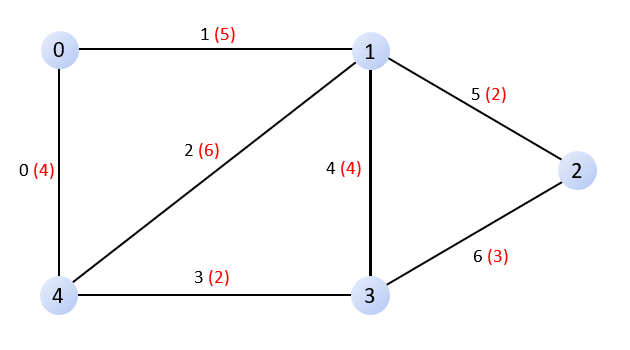

In [4]:
Image("image1.PNG")

In [5]:
G1=Graphe()
G1.ajouterArete("0","1",5)
G1.ajouterArete("0","4",4)
G1.ajouterArete("4","1",6)
G1.ajouterArete("4","3",2)
G1.ajouterArete("1","3",4)
G1.ajouterArete("1","2",2)
G1.ajouterArete("3","2",3)
arbre=Prim(G1)
ls=arbre.minArete()
print(ls)

[['3', '4', 2], ['1', '2', 2], ['2', '3', 3], ['0', '4', 4]]


On remarque que l'on obtient bien l'arbre couvrant de poids minimum que nous avions trouvé en appliquant manuellement l'algorithme. L'algorithme implémenté semble bien fonctionner. Nous le retesterons une 2ème fois plus tard en comparant les résultats avec celui de Kruskal.

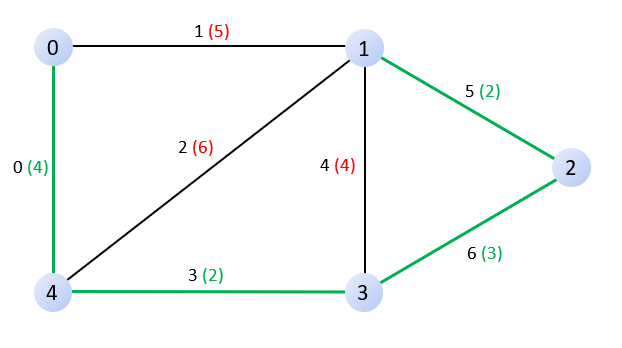

In [6]:
Image("image2.PNG")

Le 2ème algorithme qui permettait de résoudre le problème de l'arbre couvrant de poids minimum était l'algorithme de Kruskal.
Avant d'implémenter cet algorithme, nous devons créer un algorithme qui détecte la présence de cycle dans le graphe non orienté considéré :

In [7]:
#Algorithme qui détecte la présence d'un cycle dans un graphe non-orienté quelconque
    #G : Graphe non orienté
def detectionCycle(G):
    #Couleur des sommets (w : pas visité, g : visité )
    #On initialise la couleur de tous les sommets à blanc
    color={s : "w" for s in G.so}
    #On crée un dictionnaire qui enregistre le sommet par laquel chaque sommet a été colorié
    maColorie={s : "" for s in G.so}
    #Tant qu'il y a encore un sommet blanc, on continue le processus
    while(any([c=="w" for c in color.values()])):
        #On choisit un sommet aléatoire non traité
        rand=random.choice([sommet for sommet in G.so if color[sommet]=="w"]) 
        #on le rajoute dans la pile
        pile=[rand] 
        #Tant que la pile n'est pas vide , ...
        while(len(pile)>=1):
            #on traite le premier sommet de la pile
            s=pile.pop()  
            color[s]="g"
            if(s in G.ar.keys()):
                for j in G.ar[s].keys():
                    #si on rencontre un sommet gris qui n'est pas le sommet qui l'a  
                    #rajoute dans la pile , alors il y a un cycle
                    if(color[j]=="g" and not (j==maColorie[s])):   
                        return(True)
                    #si le sommet n'a pas encore été visité on l'ajoute à la pile
                    if(color[j]=="w"): 
                        maColorie[j]=s
                        pile.append(j)
    return(False)

Puis on implémente l'algorithme de Kruskal :

In [8]:
#Première version de l'Algorithme de Kruskal
    #G : un graphe simple non orienté connexe
def Kruskal(G):
    #Création de la liste des arêtes triées
    aretetrie=G.minArete()
    #On crée l'arbre qu'on va retourner à la fin
    Garbre=Graphe()
    #On y ajoute tous les sommets
    for sommet in G.so:
        Garbre.ajouterSommet(sommet)
    #Tant que l'arbre a moins de n-1 arêtes, on ajoute des arêtes
    while(Garbre.nbA<Garbre.nbS-1):
        #On prend la première arête de la liste
        arete=aretetrie[0]
        #Si elle ne crée pas de cycle, on l'ajoute, sinon on la supprime
        Garbre.ajouterArete(arete[0],arete[1],arete[2])
        if(detectionCycle(Garbre)):
            Garbre.enleverArete(arete[0],arete[1])
        del(aretetrie[0])
    #On retourne l'arbre couvrant de poids minimum
    return(Garbre)

Comme précédemment, on teste l'algorithme sur l'exemple du cours :

In [9]:
G1=Graphe()
G1.ajouterArete("0","1",5)
G1.ajouterArete("0","4",4)
G1.ajouterArete("4","1",6)
G1.ajouterArete("4","3",2)
G1.ajouterArete("1","3",4)
G1.ajouterArete("1","2",2)
G1.ajouterArete("3","2",3)
arbre=Kruskal(G1)
ls=arbre.minArete()
print(ls)

[['1', '2', 2], ['3', '4', 2], ['2', '3', 3], ['0', '4', 4]]


On remarque que l'on obtient le même resultat. Nous allons maintenant tester les 2 algorithmes sur un exemple que nous allons créer aléatoirement, et nous allons mesurer les temps d'exécution de ces derniers. Pour cela nous créons tout d'abord une fonction qui va générer un graphe aléatoire avec des valeurs d'arc aléatoires.

In [10]:
#Méthode pour générer un graphe connexe simple non orienté
    #nbSom : nombre de Sommet
    #minVal : valeur maximum d'une arête 
    #maxVal : valeur maximale d'une arête
def genGraphe(nbSom=10,minVal=0,maxVal=10):
    #On crée l graphe initial
    graphe=Graphe()
    #On ajoute des arêtes entre tous les sommets
    for i in range(1,nbSom+1):
        for j in range(i+1,nbSom+1):
            graphe.ajouterArete(str(i),str(j), random.randint(minVal,maxVal))
    #On retourne le graphe final
    return(graphe)

Nous pouvons donc maintenant créer notre graphe aléatoire. On peut désormais tester notre algorithme sur un graphe de 300 sommets

In [11]:
print("Création du graphe")
nbS=300
B=genGraphe(nbS)
print("Exécution de l'algorithme de Kruskal")
t1=time.time()
arbre1=Kruskal(B)
t2=time.time()
print(f"Le temps d'exécution est de {t2-t1}.")
print("Exécution de l'algorithme de Prim")
t1=time.time()
arbre2=Prim(B)
t2=time.time()
print(f"Le temps d'exécution est de {t2-t1}.")
ls1=arbre1.minArete()
poid1=sum([i[2] for i in ls1])
ls2=arbre2.minArete()
poid2=sum([i[2] for i in ls2])
print(f"Test pour savoir si les 2 algorithmes rendent le même resultat : {poid1==poid2}")

Création du graphe
Exécution de l'algorithme de Kruskal
Le temps d'exécution est de 4.724338054656982.
Exécution de l'algorithme de Prim
Le temps d'exécution est de 0.3803236484527588.
Test pour savoir si les 2 algorithmes rendent le même resultat : True


On observe alors que les 2 algorithmes donnent le même resultat. En revanche, on observe que l'algorithme de Kruskal est un peu plus long que l'algorithme de Prim en général. Notre objectif est maintenant d'optimiser la complexité de ces derniers.

### 2) Optimisation des algorithmes

Pour cela, nous commencons tout d'abord par optimiser l'algorithme de Prim. L'étape qui prend le plus de temps dans l'éxecution est de trouver le minimum. Pour cela, nous allons utiliser la structure de tas-min binaire qui nous permet de trouver le minimum très rapidement car c'est le premier élément de la liste. Pour le concept de tas min binaire, nous utilisons le module heapq dans lequel toutes les méthodes dont nous avons besoin sont déjà implémentées. Voici donc la 2ème version de l'algorithme de Prim :

In [12]:
#Deuxième version de l'Algorithme de Prim
    #G : un graphe simple non orienté connexe
def Prim2(G):
    #Création de l'Arbre Couvrant de poids minimal
    Gfinal=Graphe()
    #Choix d'un sommet aléatoire que l'on rajoute à l'arbre
    choice=random.choice(G.so)
    Gfinal.ajouterSommet(choice)
    #Création d'un tas min binaire
    heap=[]
    #Ajout de toutes les arêtes ayant le premier sommet comme extrémité
    #au tas min binaire
    for key2 in G.ar[choice].keys():
        heappush(heap , (G.ar[choice][key2],choice,key2))
    #Tant que l'arbre couvrant de poids minimum n'est pas composé de tous les sommets,
    #on prend le minimum des arêtes dans le tas min
    while Gfinal.nbS < G.nbS:
        #Récupération du minimum
        minimum=heappop(heap)
        #On regarde si les extrémités sont déjà dans l'arbre couvrant
        extremite1= minimum[1] in Gfinal.so
        extremite2= minimum[2] in Gfinal.so
        #Si il y en a une présente dans le graphe et l'autre non alors on l'ajoute à l'arbre
        if extremite1+extremite2<2:
            #On ajoute toutes les arêtes ayant pour extrémité le sommet qui n'est pas déjà dans l'arbre
            if extremite1:
                for key2 in G.ar[minimum[2]].keys():
                    heappush(heap , (G.ar[minimum[2]][key2] ,minimum[2],key2))
            else :
                for key2 in G.ar[minimum[1]].keys():
                    heappush(heap ,(G.ar[minimum[1]][key2],minimum[1],key2))
            #On ajoute l'arête à l'arbre
            Gfinal.ajouterArete(minimum[1],minimum[2],minimum[0])
    #On retourne l'arbre couvrant de poids minimum
    return(Gfinal)

Comme précédémment, on effectue un test sur l'exemple basique du cours

In [13]:
G1=Graphe()
G1.ajouterArete("0","1",5)
G1.ajouterArete("0","4",4)
G1.ajouterArete("4","1",6)
G1.ajouterArete("4","3",2)
G1.ajouterArete("1","3",4)
G1.ajouterArete("1","2",2)
G1.ajouterArete("3","2",3)
arbre=Prim2(G1)
ls=arbre.minArete()
print(ls)

[['1', '2', 2], ['3', '4', 2], ['2', '3', 3], ['0', '4', 4]]


On obtient alors le bon résultat. Nous revérifirons une deuxième fois la validité de l'algorithme lorsque nous le comparerons avec les autres.

Le deuxième algorithme que nous allons optimiser est l'algorithme de Kruskal. Cette fois-ci la partie que nous allons optimiser est la recherche d'un cycle. En effet, nous ne travaillons pas avec un arbre non orienté quelconque mais avec un arbre donc un graphe acyclique auquel nous ajoutons une arête. Au moment d’ajouter une arête $\{u, v\}$ dans $T$, on détecte alors un cycle en regardant simplement si $v$ est dans la liste des sommets que l’on peut atteindre depuis $u$. Pour cela, pour repérer la présence d'un cycle, nous allons utiliser une structure de type Union-Find qui va réunir les sommets sous forme de groupe. Voici quelques fonctions qui vont nous êtres utiles pour la suite afin d'utiliser cette structure :

In [14]:
#Fonction qui permet de trouver la racine d'un sommet dans une structure unionFind
    #sommet :  sommet à qui on veut trouver sa racine
    #unionFind : dictionnaire contenant pour chaque sommet soit un nombre négatif pour la racine d'une classe réprésentant
    #la taille de la classe soit un nombre positif représentant le parent du sommet
def find(sommet,unionFind):
    #Si le nombre est négatif alors on a trouvé la racine de la classe
    if int(unionFind[sommet]) <0:
        return sommet
    #Sinon on réapelle la fonction avec le père du sommet
    parent=find(unionFind[sommet],unionFind)
    return(parent)

#Fonction qui permet de faire l'union de 2 sommets dans une structure unionFind
    #s1 : 1er sommet
    #s2 : 2ème sommet
    #unionFind : dictionnaire contenant pour chaque sommet soit un nombre négatif pour la racine d'une classe réprésentant
    #la taille de la classe soit un nombre positif représentant le parent du sommet
def union(s1,s2,unionFind):
    #On récupère la racine du groupe de s1 et de s2
    racines1=find(s1,unionFind)
    racines2=find(s2,unionFind)
    #Si ils ont la même racine, alors on fait rien
    if racines1==racines2:
        return 
    #Sinon, pour la classe la plus grande en taille, on y ajoute toute l'autre classe
    if int(unionFind[racines1]) > int(unionFind[racines2]):
        unionFind[racines2]+=unionFind[racines1]
        unionFind[racines1]=racines2
    else:
        unionFind[racines1]+=unionFind[racines2]
        unionFind[racines2]=racines1 

On peut donc implémenter une deuxième version de l'algorithme de Kruskal :

In [15]:
#Deuxième version de l'Algorithme de Kruskal
    #G : un graphe simple non orienté connexe
def Kruskal2(G):
    #Création de la liste des arêtes triées
    aretetrie=G.minArete()
    #On définit la structure union find
    unionFind={ i : -1 for i in G.so }
    #On crée l'arbre qu'on va retourner à la fin
    Garbre=Graphe()
    #On y ajoute tous les sommets
    for sommet in G.so:
        Garbre.ajouterSommet(sommet)
    #Tant que l'arbre a moins de n-1 arêtes, on ajoute des arêtes
    while(Garbre.nbA < Garbre.nbS-1):
        #On prend la première arête de la liste
        arete=aretetrie[0]
        #Si les arêtes n'appartiennent pas au même groupe alors on peut ajouter l'arête à l'arbre
        #et regrouper les 2 grouoes dans la structure unionFind
        if(find(arete[0],unionFind) != find(arete[1],unionFind)):
            Garbre.ajouterArete(arete[0],arete[1],arete[2])
            union(arete[0],arete[1],unionFind)
        #On supprime l'arête de la liste
        del(aretetrie[0])
    #On retourne l'arbre couvrant de poids min
    return(Garbre)

Comme précédemment, on vient tester cet algorithme sur l'exemple basique du cours

In [16]:
G1=Graphe()
G1.ajouterArete("0","1",5)
G1.ajouterArete("0","4",4)
G1.ajouterArete("4","1",6)
G1.ajouterArete("4","3",2)
G1.ajouterArete("1","3",4)
G1.ajouterArete("1","2",2)
G1.ajouterArete("3","2",3)
arbre=Kruskal2(G1)
ls=arbre.minArete()
print(ls)

[['1', '2', 2], ['3', '4', 2], ['2', '3', 3], ['0', '4', 4]]


On obtient alors le bon résultat. Nous allons maintenant comparer leurs vitesses d'execution respectives et regarder si il donnent tous les 4 le même résultat. Pour cela, nous créons tout d'abord une deuxième méthode pour générer un graphe qui cette fois prend la valeur d'arête souhaité en paramètre et ne crée donc pas une arête entre tous les sommets :

In [17]:
#Méthode pour générer un graphe connexe simple non orienté
    #nbSom : nombre de Sommet
    #minVal : valeur maximum d'une arête 
    #maxVal : valeur maximale d'une arête
def genGraphe2(nbS=10,nbA=100,minVal=1,maxVal=1000):
    #On crée le graphe initial
    graphe=Graphe()
    #On répertorie toutes les possibilités d'arêtes possibles
    possibilite = [ [i,j]   for i in range(1,nbS+1) for j in range(i+2,nbS+1)]
    #On crée un cycle trivial dans le graphe afin qu'il soit connexe
    for i in range(1,nbS+1):
        graphe.ajouterArete(str(i),str((i % nbS) + 1),random.randint(minVal,maxVal))
    #On complete le graphe par des arêtes choisies au hasard parmi celle possible
    for choice in random.sample(possibilite,k=min((nbA-nbS),len(possibilite))):
        graphe.ajouterArete(str(choice[0]),str(choice[1]),random.randint(minVal,maxVal))
    #On retourne le graphe
    return(graphe)

### 3) Etude de la complexité

Nous nous intéressons maintenant à la comparaison de manière qualitative des temps d'éxécution de ces 4 algorithmes pour un graphe à 500 sommets et 4000 arêtes.

In [18]:
print("Création du graphe")
nbS=500
nbA=4000
B=genGraphe2(nbS,nbA)
print("Exécution de la première version de l'algorithme de Kruskal")
t1=time.time()
arbre1=Kruskal(B)
t2=time.time()
print(f"Le temps d'exécution est de {t2-t1}.")

print("Exécution de la première version de l'algorithme de Prim")
t1=time.time()
arbre2=Prim(B)
t2=time.time()
print(f"Le temps d'exécution est de {t2-t1}.")

print("Exécution de la deuxième version de l'algorithme de Kruskal")
t1=time.time()
arbre3=Kruskal2(B)
t2=time.time()
print(f"Le temps d'exécution est de {t2-t1}.")

print("Exécution de la deuxième version de l'algorithme de Prim")
t1=time.time()
arbre4=Prim2(B)
t2=time.time()
print(f"Le temps d'exécution est de {t2-t1}.")

ls1=arbre1.minArete()
poid1=sum([i[2] for i in ls1])
ls2=arbre2.minArete()
poid2=sum([i[2] for i in ls2])
ls3=arbre3.minArete()
poid3=sum([i[2] for i in ls3])
ls4=arbre4.minArete()
poid4=sum([i[2] for i in ls4])
print(f"Test pour savoir si les 4 algorithmes rendent le même resultat : {poid1==poid2 and poid2==poid3 and poid3==poid4}")

Création du graphe
Exécution de la première version de l'algorithme de Kruskal
Le temps d'exécution est de 20.13783860206604.
Exécution de la première version de l'algorithme de Prim
Le temps d'exécution est de 1.005688190460205.
Exécution de la deuxième version de l'algorithme de Kruskal
Le temps d'exécution est de 0.04788374900817871.
Exécution de la deuxième version de l'algorithme de Prim
Le temps d'exécution est de 0.0659945011138916.
Test pour savoir si les 4 algorithmes rendent le même resultat : True


On remarque que les 4 algorithmes nous donnent bien le même poids final donc les 4 algorithmes semblent bien fonctionner. De plus, on observe que les deuxièmes versions des algorithmes s'éxecutent beaucoup plus vite. Pour avoir une approche plus quantitative, nous allons réaliser une étude de complexité pour les 4 algorithmes. Tout d'abord, on compare le temps d'exécution des 4 algorithmes pour des valeurs de n différentes et avec $m=n*20$.

100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 

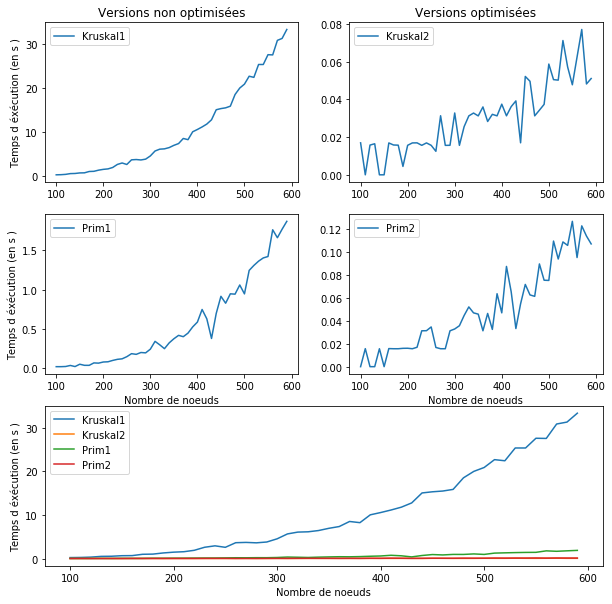

In [19]:
#Initialisation des listes qui vont stockes nos données
nTest=[ i*10 for i in range(10,60,1)]
tkruskal2=[]
tkruskal1=[]
tprim1=[]
tprim2=[]
o=[]

#On réalise le test pour plusieurs valeurs de n
for i in nTest:
    print(i, end=" ")
    B=genGraphe2(i,i*10)
    
    #Kruskal2
    t1=time.time()
    arbre1=Kruskal2(B)
    t2=time.time()
    tkruskal2.append(t2-t1)
    
    #Kruskal1 
    t1=time.time()
    arbre1=Kruskal(B)
    t2=time.time()
    tkruskal1.append(t2-t1)

    #Prim2   
    t1=time.time()
    arbre1=Prim2(B)
    t2=time.time()
    tprim2.append(t2-t1)

    #Prim1  
    t1=time.time()
    arbre1=Prim(B)
    t2=time.time()
    tprim1.append(t2-t1)
    #On stocke la valeur de n  
    o.append(i)

#On affiche le tout
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.plot(nTest,tkruskal1,label="Kruskal1")
plt.title('Versions non optimisées')
plt.ylabel("Temps d éxécution (en s )")
plt.legend()

plt.subplot(3,2,2)
plt.plot(nTest,tkruskal2,label="Kruskal2")
plt.title('Versions optimisées')
plt.legend()

plt.subplot(3,2,3)
plt.plot(nTest,tprim1,label="Prim1")
plt.xlabel('Nombre de noeuds')
plt.ylabel("Temps d éxécution (en s )")
plt.legend()

plt.subplot(3,2,4)
plt.plot(nTest,tprim2,label="Prim2")
plt.xlabel('Nombre de noeuds')
plt.legend()

plt.subplot(3,2,(5,6))
plt.plot(nTest,tkruskal1,label="Kruskal1")
plt.plot(nTest,tkruskal2,label="Kruskal2")
plt.plot(nTest,tprim1,label="Prim1")
plt.plot(nTest,tprim2,label="Prim2")
plt.xlabel('Nombre de noeuds')
plt.ylabel("Temps d éxécution (en s )")
plt.legend()

plt.show()

On observe alors que l'algorithme le plus long est la première version de celui de Kruskal. De plus, nos 2 algorithmes optimisés sont les plus rapides.
Maintenant, on aimerait bien identifier la complexité de ces derniers. La problème de cette étape est que la compléxité dépend de $n$ et de $m$.
Commencons par l'algorithme de Kruskal qui possède théoriquement la plus grande complexité.

En effet, le tri se fait en $O(m \times log(m))$ et réalise au maximum $m$ itérations dans lesquels on recherche un cycle dans un graphe d'au maximum $n-1$ arêtes et connexe ( complexité en $O(n)$ ). Par conséquent, la complexité du tri est négligeable devant la complexité de la boucle et Kruskal a une complexité théorique en $O(m \times n)$.
Nous allons alors tenter de comparer cette complexité aux temps d'execution. Pour cela, on va venir faire une interpolation de la courbe du temps d'execution avec un polynome de degré 1  en $n \times m$. On pourra alors vérifier si les courbes sont proches.


100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 

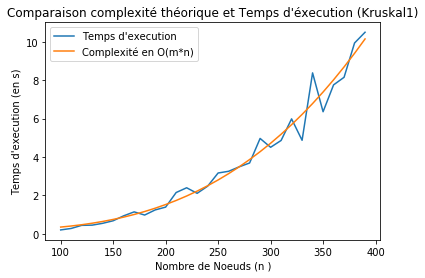

In [20]:
#Déclaration des différentes valeurs de n et des listes m , n et du temps d'execution de Kruskal
nTest=[ i*10 for i in range(10,40)]
n=[]
m=[]
tkruskal=[]
#On réalise le test pour plusieurs valeurs de n
for i in nTest:
    print(i,end=" ")
    #On génère le graphe, et on sauvegarde n et m
    B=genGraphe2(i,i*10+i*i)
    n.append(B.nbS)
    m.append(B.nbA)
    
    #Calcul du temps d'execution de Kruskal
    t1=time.time()
    arbre1=Kruskal(B)
    t2=time.time()
    tkruskal.append(t2-t1)

#Interpolation du temps d'execution en un polynome de degré 1 en fonction de la complexité théorique
p=np.polyfit(np.array(n)*np.array(m),tkruskal,1)
ypol=p[1]+p[0]*np.array(n)*np.array(m)

#On affiche nos résultats
plt.plot(np.array(n),tkruskal,label="Temps d'execution")
plt.plot(np.array(n),ypol,label="Complexité en O(m*n)")
plt.legend()
plt.title("Comparaison complexité théorique et Temps d'éxecution (Kruskal1)")
plt.xlabel("Nombre de Noeuds (n )")
plt.ylabel("Temps d'execution (en s)")
plt.show()

On peut alors observer que la courbe s'adapte parfaitement au temps d'execution. Par conséquent, on peut confirmer que l'algorithme a une complexité en $O(m \times n)$.

Passons maintenant a l'algorithme de Prim. 
En ce qui concerne la complexité théorique , il possède aussi le tri en $O(m \times log(m))$. Ensuite, cela va beaucoup varier en fonction du graphe. En effet, dans l'algoritme du cours, la complexite est en $O(n\times n)$. On l'obtient en gardant en mémoire pour tous sommets n'appartenant pas à l'arbre la distance minimale allant d'un sommet appartenant déjà à l'arbre à ce dernier .Notre premier algorithme n'est pas aussi optimisé. En effet, ici nous avons dans la boucle nous avons $n$ itération et lors d'une itération on va passer aux alentours de $O(n)$ fois dans la boucle while avec $n O(n)$ comparaisons . On obtient donc une complexité en $O(n \times n \times n)$.

100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 

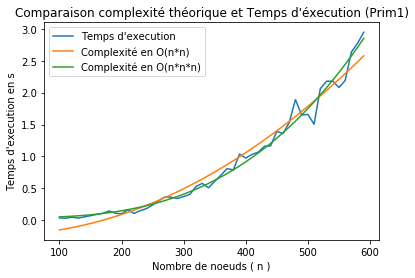

In [21]:
#Déclaration des différentes valeurs de n et des listes m , n et du temps d'execution de Prim
nTest=[ i*10 for i in range(10,60)]
n=[]
m=[]
tprim=[]
#On réalise le test pour plusieurs valeurs de n
for i in nTest:
    print(i,end=" ")
    #On génère le graphe, et on sauvegarde n et m
    B=genGraphe2(i,i*10+i*i)
    n.append(B.nbS)
    m.append(B.nbA)
    
    #Calcul du temps d'execution de Prim
    t1=time.time()
    arbre1=Prim(B)
    t2=time.time()
    tprim.append(t2-t1)

#Interpolation du temps d'execution en un polynome de degré 1 en fonction de la complexité théorique
p1=np.polyfit(np.array(n)*np.array(n),tprim,1)
ypol1=p1[1]+p1[0]*np.array(n)*np.array(n)
p2=np.polyfit(np.array(n)*np.array(n)*np.array(n),tprim,1)
ypol2=p2[1]+p2[0]*np.array(n)*np.array(n)*np.array(n)

#On affiche nos résultats
plt.plot(np.array(n),tprim,label="Temps d'execution")
plt.plot(np.array(n),ypol1,label="Complexité en O(n*n)")
plt.plot(np.array(n),ypol2,label="Complexité en O(n*n*n)")
plt.ylabel("Temps d'execution en s")
plt.xlabel('Nombre de noeuds ( n )')
plt.title("Comparaison complexité théorique et Temps d'éxecution (Prim1)")
plt.legend()
plt.show()

On observe bien le résultat énoncé ci-dessus. Le temps d'éxécution de l'algorithme s'adapte parfaitement à la courbe lié à la complexité en $O(n^3)$ alors que la complexité en $O(n^2)$ est très faible. On obtient donc pas la complexité énoncée dans le cours mais cela n'a pas d'importance puisque que nous avons optimisée celui-ci ensuite.

Intéressons nous alors à la deuxième version de l'algorithme de Prim.
Théoriquement, la boucle va faire au maximum $m$ itération. De plus, pour chaque itération on va retirer le premier élément du tas min binaire ce qui se fait en $log($nbElement$)$. De plus, lorsqu'on rajoute un élément à l'arbre on y ajoute toutes ces arrêtes dans le tas donc on le fait $2 \times m$ fois et cette opération est en $log($nbElement$)$.On obtient ainsi une complexité en $O(m \times log($nbElement$))$.Dans notre cas, le nombre d'element dans le tas varie à chaque tour on sait que le tas vas être au maximum de $m-n$ élément. On obtient alors une complexité entre $O(m \times log(n))$ et  $O(m \times log(m-n))$.Ce n'est pas la plus optimisée avec les tas min binaire. On aurait pu aller jusqu'à $O(m \times log(n))$ en prenant un tas min binaire des sommets et non de toutes les arêtes. Comparons cela, avec les temps d'exécution.

100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 

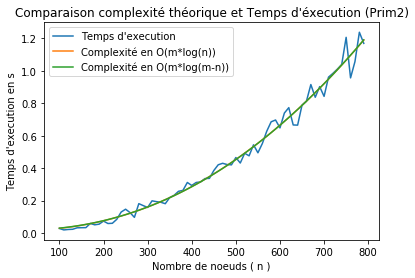

In [22]:
#Déclaration des différentes valeurs de n et des listes m , n et du temps d'execution de Prim2
nTest=[ i*10 for i in range(10,80)]
n=[]
m=[]
tprim=[]
#On réalise le test pour plusieurs valeurs de n
for i in nTest:
    print(i,end=" ")
    #On génère le graphe, et on sauvegarde n et m
    B=genGraphe2(i,i*10+i*i)
    n.append(B.nbS)
    m.append(B.nbA)
    
    #Calcul du temps d'execution de Prim2
    t1=time.time()
    arbre1=Prim2(B)
    t2=time.time()
    tprim.append(t2-t1)

#Interpolation du temps d'execution en un polynome de degré 1 en fonction de la complexité théorique
p1=np.polyfit(np.array(m)*np.array(np.log(n)),tprim,1)
ypol1=p1[1]+p1[0]*np.array(m)*np.array(np.log(n))
p2=np.polyfit(np.array(m)*np.array(np.log(np.array(m)-np.array(n))),tprim,1)
ypol2=p2[1]+p2[0]*np.array(m)*np.array(np.log(np.array(m)-np.array(n)))

#On affiche nos résultats
plt.plot(np.array(n),tprim,label="Temps d'execution")
plt.plot(np.array(n),ypol1,label="Complexité en O(m*log(n))")
plt.plot(np.array(n),ypol2,label="Complexité en O(m*log(m-n))")
plt.ylabel("Temps d'execution en s")
plt.xlabel('Nombre de noeuds ( n )')
plt.title("Comparaison complexité théorique et Temps d'éxecution (Prim2)")
plt.legend()
plt.show()

Ici, on ne voit pas beaucoup de différence car $n$ et $m$ sont assez "proche". En revanche, si on augmentait $m$ pourqu'il soit beaucoup plus grand, on pourrait voir apparaitre la différence. Dans tout les cas, on remarque que la complexité de notre algorithme est en $O(m \times log(m-n))$.

Enfin, pour la deuxième version de Kruskal, on obtient la complexité théorique suivante :
Nous n'avons plus la recherche de cycle basique à chaque itération. Au moment d’ajouter une arête $\{u, v\}$ dans $T$, on détecte alors un cycle en regardant simplement si $v$ est dans la liste des sommets que l’on peut atteindre
depuis $u$. Grâce à la structure Union-Find , le maintien des listes de sommets accessibles et la
détection de cycle peuvent alors être faits en $O(log(n))$. Par conséquent, l'exécution de la boucle est maintenant en $O(m \times log(n))$ ce qui est cette fois négligeable devant la complexité du tri et l'algorithme de Kruskal est maintenant en $O(m \times log(m))$.
Comparons cela avec l'allure du temps d'exécution.

100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 

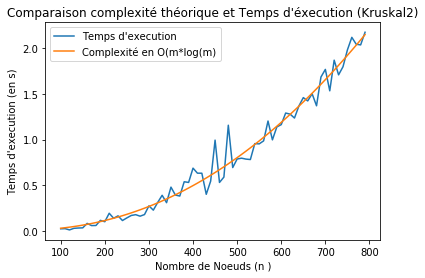

In [23]:
#Déclaration des différentes valeurs de n et des listes m , n et du temps d'execution de Kruskal2
nTest=[ i*10 for i in range(10,80)]
n=[]
m=[]
tkruskal=[]
#On réalise le test pour plusieurs valeurs de n
for i in nTest:
    print(i,end=" ")
    #On génère le graphe, et on sauvegarde n et m
    B=genGraphe2(i,i*10+i*i)
    n.append(B.nbS)
    m.append(B.nbA)
    
    #Calcul du temps d'execution de Kruskal2
    t1=time.time()
    arbre1=Kruskal2(B)
    t2=time.time()
    tkruskal.append(t2-t1)

#Interpolation du temps d'execution en un polynome de degré 1 en fonction de la complexité théorique
p=np.polyfit(np.array(m)*np.array(np.log(np.array(m))),tkruskal,1)
ypol=p[1]+p[0]*np.array(m)*np.array(np.log(np.array(m)))

#On affiche nos résultats
plt.plot(np.array(n),tkruskal,label="Temps d'execution")
plt.plot(np.array(n),ypol,label="Complexité en O(m*log(m)")
plt.legend()
plt.title("Comparaison complexité théorique et Temps d'éxecution (Kruskal2)")
plt.xlabel("Nombre de Noeuds (n )")
plt.ylabel("Temps d'execution (en s)")
plt.show()

On observe alors une dernière fois que la complexité théorique s'adapte parfaitement à la courbe de l'évolution du temps d'execution. Par conséquent, on confirme que l'algorithme optimisée de Kruskal a une complexité en $O(m \times log(m))$.

Nous avons donc pu étudier la complexité de tous les alogrithmes. On peut alors en déduire que l'algorithme qui est le plus rapide asymptotiquement est l'algorithme de Prim avec sa complexité en $O(m \times log(m-n))$. On peut alors tester cela sur une valeur de $m$ et $n$ très grande. On prend dans l'exemple ci-dessous $n=5000$ et $m=1000000$. Nous nous intéressons qu'aux 2 algorithmes optimisés car les autres prennent beaucoup trop de temps à s'exécuter.

In [24]:
print("Création du graphe")
nbS=5000
nbA=1000000 
B=genGraphe2(nbS,nbA)

print("Exécution de la deuxième version de l'algorithme de Kruskal")
t1=time.time()
arbre3=Kruskal2(B)
t2=time.time()
print(f"Le temps d'exécution est de {t2-t1}.")

print("Exécution de la deuxième version de l'algorithme de Prim")
t1=time.time()
arbre4=Prim2(B)
t2=time.time()
print(f"Le temps d'exécution est de {t2-t1}.")

Création du graphe
Exécution de la deuxième version de l'algorithme de Kruskal
Le temps d'exécution est de 24.600974321365356.
Exécution de la deuxième version de l'algorithme de Prim
Le temps d'exécution est de 24.60885214805603.


On confirme donc que l'algorithme de Prim est le plus rapide asymptotiquement. Ici, ce qui nous bloque pour aller plus loin dans la construction de grands graphes c'est la construction de graphe avec la fonction genGraphe2, une amélioration sera alors d'optimiser cette fonction. 
Pour conclure sur cette première partie, nous avons tout d'abord implémenté des premières versions de Kruskal et Prim avec des complexités respectives en $O(m \times n)$ et $O(n \times n \times n)$ puis nous avons optimisé les algorithmes afin d'obtenir de nouvelles versions en $O(m \times log(m))$ et $O(m \times log(m-n))$. Si nous voulions continuer à optimiser nos algorithmes, on pourrait optimiser l'algorithme de Prim avec les tas min binaire jusqu'à obtenir une compléxite en $O(m \times log(n))$ ou même implémenter une version de Prim avec les tas de fibonacci qui permettent d'obtenir une complexité en $O(m+n \times log(n))$.

## II) Arbre couvrant de poids minimum : Modélisation PLNE

Nous allons maintenant modéliser le problème de l'arbre couvrant de poids minimum comme un programme linéaire en nombre entier. Pour cela nous utiliserons la librairie PuLP:

In [25]:
from pulp import*
import numpy as np
from itertools import combinations
import re
import math as m

### 1) Premier modèle

On considère comme précédemment un graphe non-orienté connexe $G=[S,A]$ dont chaque arête possède un poids $p_{a}$. On note désormais $n=|S|$ et $m=|A|$. Par la suite, chaque sommet sera numéroté de $0$ à $n-1$ et chaque arête sera numérotée de $0$ à $m-1$. On définit donc notre modèle :

*Variables :*
- $\forall a \in A, x_a\in \{0,1\}$ et $x_a=1$ si l'arrête $a$ est dans l'arbre couvrant de poids minimum.

*Objectif :*

- On cherche à minimiser la somme des poids des arêtes contenues dans l'arbre : 

$$\min{\sum_{a\in A}{x_ap_a}}$$ 

*Contraintes :*

Il faut que le graphe obtenu soit un arbre, on impose donc les 2 contraintes suivantes:

- Il faut qu'il y ait exactement $|S|-1$ arêtes soit $n-1$ arêtes:

$$\begin{equation}
    {\sum_{a\in A}{x_a}=n-1}
    \end{equation}$$

- Pour assurer la connexité et éviter la présence de cycles, chaque sous-ensemble $\bar{S}\subset S$ doit avoir au plus $|\bar{S}|-1$ arêtes : 

$\begin{equation}
    \sum_{a\in \bar{A}}{x_a} \le |\bar{S}|-1
    \end{equation}$, $\forall \bar{S}\subset S$ et $\bar{A}$ l'ensemble des arêtes dont les 2 sommets sont dans $\bar{S}$.


On crée donc d'abord une fonction chargée de construire le modèle. Elle prendra en argument la liste d'incidence du graphe (sous forme d'un dictionnaire dont les clé sont les sommets et les valeurs les arêtes ayant une extrémité dans ces sommets) ainsi qu'un dictionnaire contenant les poids de chaque arête et dont la numérotation des arêtes correspond à celle de la liste. Cette fonction renvoie le modèle non résolu.

In [26]:
def ModelePLNE_1(Liste,Poids):
    
    #Création du problème :
    prob = LpProblem("ACPM_1",LpMinimize)
    
    n = len(Liste.keys()) #Nombre de sommets
    m = len(Poids.keys()) #Nombre d'arêtes
    S = list(Liste.keys()) #Liste des sommets
    A = list(Poids.keys()) #Liste des arêtes
    
    #Variable :
    x={}
    for i in A:
        x[i] = LpVariable("x"+"_"+str(i),0,1,LpInteger)

            
    #Objectif :
    prob += lpSum([x[i]*Poids[i] for i in A])

    #Contraintes :
    
    prob += lpSum([x[i] for i in A]) == n-1
    
    for k in range(3,n):
        L = list(combination(S,k))
        for ensemble in L:
            E = []
            for arc in A:
                for sommet1 in ensemble:
                    for sommet2 in ensemble:
                        if(sommet1 != sommet2 and arc in Liste[sommet1] and arc in Liste[sommet2] and arc not in E):
                            E.append(arc)
            prob += lpSum([x[a] for a in E])<=k-1
                
    #Retour du problème :
    return(prob)

*Remarque :*

Pour modéliser la seconde contrainte, nous avons considéré toutes les combinaisons de $k\in\{3,...,n-1\}$ sommets parmi $n$ sommets au total pour décrire les sous-ensembles $\bar{S}\subset S$. Le nombre de contraintes **NbCTR** pour un graphe donné en entrée de $n$ sommets sera donc :

$NbCTR = 1+\sum_{k=3}^{n-1}{C_n^k}=\sum_{k=0}^{n}{C_n^k}+1-C_n^0-C_n^1-C_n^2-C_n^n=2^n-n-\frac{n(n-1)}{2}-1$

Pour un graphe (de $n$ sommets et de $m$ arêtes) donné en entrée, ce premier modèle contiendra $m$ variables et $2^n-n-\frac{n(n-1)}{2}-1$ contraintes.

On crée ensuite une fonction permettant de résoudre le problème et de l'afficher. Cette fonction prend en paramètre le modèle, son nom et une variable booléenne. Si cette dernière est VRAI, on affichera le modèle complet et sa solution en affichant les valeurs de toutes les variables (pour ne pas encombrer l'affichage, seuls les variables $x_a$ égales à 1 seront affichées). Si elle est FAUSSE, la fonction affiche simplement la solution en indiquant seulement le numéro des arêtes présentes dans l'arbre final ainsi que le poids total de cet arbre.

In [27]:
def SolveAndPrint_1(Modele,name,Affichage_modele = 0): 
    if(Affichage_modele):
        #Affichage du modèle
        Modele.writeLP(name)
        print(Modele)
        #Résolution:
        print("Solve with CBC")
        Modele.solve(PULP_CBC_CMD())
        print("Status :",LpStatus[Modele.status])
        #Affichage de la solution :
        print("Optimal value =",value(Modele.objective))
        print("Optimal solution :")
        for v in Modele.variables():
            if(v.varValue != 0):
                print(v.name,"=",v.varValue)
    else:
        #Résolution:
        print("Solve with CBC")
        Modele.solve(PULP_CBC_CMD())
        print("Status :",LpStatus[Modele.status])
        AretesTraites = []
        regexp = re.compile(r"_(\w+)")
        for v in Modele.variables():
            if(v.varValue != 0 and v.name[0] == 'x'):
                result = regexp.search(v.name)
                if result != None:
                    i = result.group(1)
                    AretesTraites.append(i)
        for arete in AretesTraites:
            print("L'arbre contient l'arête n°",arete)
        print('Le poids de total de l\'arbre est de : ',value(Modele.objective))

*Exemples et tests :*

Nous allons maintenant tester ces fonctions sur des exemples (dont l'exemple du cours) :

*Exemple n°1:*

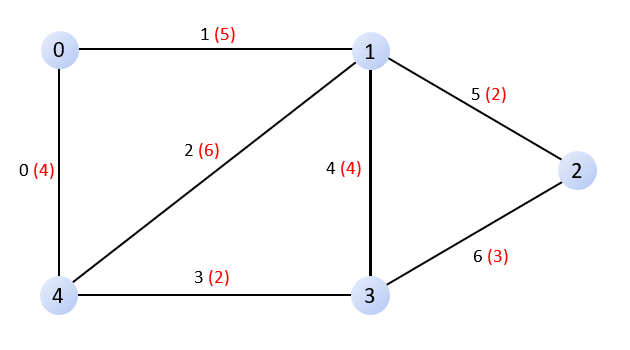

In [28]:
Image("image1.PNG")

Ce graphe possède $5$ sommets, il y aura donc $16$ contraintes. 

In [29]:
#Création de la liste d'incidence du graphe:
L1 = {0:{0,1},1:{1,2,4,5},2:{5,6},3:{3,4,6},4:{0,2,3}}
    
#Création du dictionnaire des poids:
P1 = {0:4,1:5,2:6,3:2,4:4,5:2,6:3}

#Recherche de l'arbre couvrant de poids minimum (ACPM):
SolveAndPrint_1(ModelePLNE_1(L1,P1),"ACPM Exemple n°1")

Solve with CBC
Status : Optimal
L'arbre contient l'arête n° 0
L'arbre contient l'arête n° 3
L'arbre contient l'arête n° 5
L'arbre contient l'arête n° 6
Le poids de total de l'arbre est de :  11.0


Obtient ainsi l'arbre suivant. On retrouve bien le même résultat obtenu avec l'implémentation des algorithmes de Prim et de Kruskal :

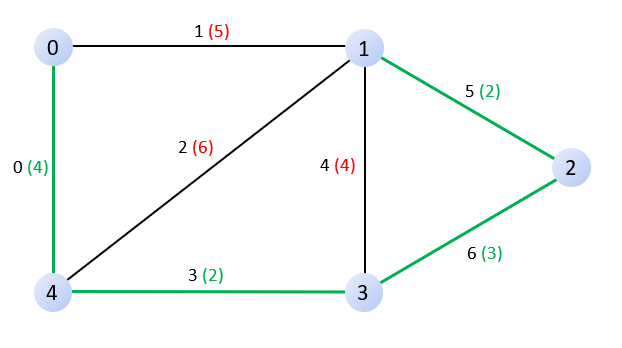

In [30]:
Image("image2.PNG")

*Exemple n°2:*

On essaye maintenant notre programme sur un graphe possèdant cette fois-ci plus de sommets. Le graphe suivant possède $10$ sommets, il y aura donc $968$ contraintes dans notre programme.

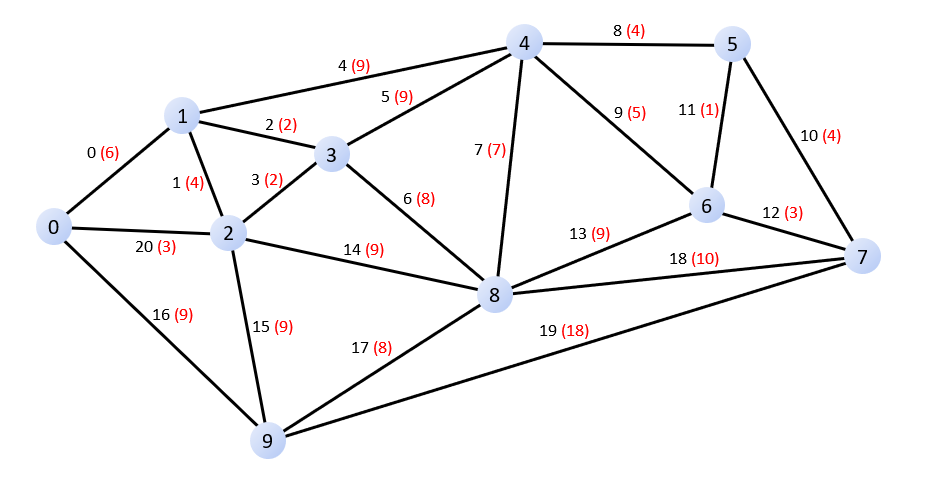

In [31]:
Image("image3.PNG")

In [32]:
#Création de la liste d'incidence du graphe:
L2 = {0: {0, 16, 20},
      1: {0, 1, 2, 4},
      2: {1, 3, 14, 15, 20},
      3: {2, 3, 5, 6},
      4: {4, 5, 7, 8, 9},
      5: {8, 10, 11},
      6: {9, 11, 12, 13},
      7: {10, 12, 18, 19},
      8: {6, 7, 13, 14, 17, 18},
      9: {15, 16, 17, 19}}
    
#Création du dictionnaire des poids:
P2={}
    
P2[0]=6; P2[1]=4; P2[2]=2; P2[3]=2; P2[4]=9
P2[5]=9; P2[6]=8; P2[7]=7; P2[8]=4; P2[9]=5
P2[10]=4; P2[11]=1; P2[12]=3; P2[13]=9; P2[14]=9
P2[15]=9; P2[16]=9; P2[17]=8; P2[18]=10; P2[19]=18
P2[20]=3

#Recherche de l'arbre couvrant de poids minimum (ACPM):
SolveAndPrint_1(ModelePLNE_1(L2,P2),"ACPM Exemple n°2")

Solve with CBC
Status : Optimal
L'arbre contient l'arête n° 11
L'arbre contient l'arête n° 12
L'arbre contient l'arête n° 17
L'arbre contient l'arête n° 2
L'arbre contient l'arête n° 20
L'arbre contient l'arête n° 3
L'arbre contient l'arête n° 6
L'arbre contient l'arête n° 7
L'arbre contient l'arête n° 8
Le poids de total de l'arbre est de :  38.0


 On obtient ainsi le résultat suivant. Le sous-graphe retenu est bien un arbre (c'est un graphe connexe et acyclique) et la somme des poids de toutes les arêtes est minimum :

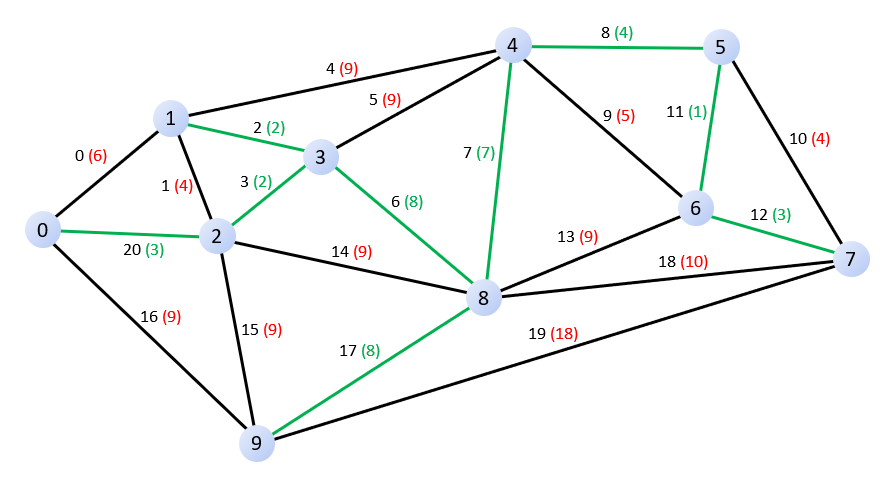

In [33]:
Image("image4.PNG")

Il serait maintenant intéressant de tester ce modèle sur des graphes généré aléatoirement (afin d'étudier plus en détail ses performances sur des graphes de grande taille). Précédemment, nous avons crée une fonction *genGraphe2* permettant de générer un graphe connexe non orienté d'un taille donnée (nombre d'arêtes et de sommets) dont chacun des ses arcs possède un poids. Le graphe crée possède un double dictionnaire contenant ses arêtes et les poids associés. Nous allons donc créer une fonction "ConvertirListe" qui à partir de ce double dictionnaire créé la liste d'incidence du graphe et un dictionnaire de poids qui lui est associé.

In [34]:
def ConvertirListe(Dictionnaire):
    Aretes = {}
    Poids = {}
    Adjacence = {}
    k = 0
    for i in Dictionnaire:
        for j in Dictionnaire[i]:
            if({i,j} not in Aretes.values()):
                Aretes[k] = {i,j}
                Poids[k] = Dictionnaire[i][j]
                k +=1
    for v in Dictionnaire:
        L =[]
        for a in Aretes:
            if v in Aretes[a]:
                L.append(a)
        Adjacence[v] = set(L)
    return(Adjacence,Poids)
    

On peut maintenant tester ce modèle sur des graphes générés aléatoirement. On compare également la solution obtenue avec le modèle PLNE avec celles des algorithmes de Prim et de Kruskal (On n'affichera que les poids des arbres obtenus pour les algorithmes de Prim et Kruskal) :

In [35]:
#On génère un graphe non orienté connexe de 15 sommets 
G3 = genGraphe2(10,20,1,10)

#On récupère la liste d'incidence du graphe ainsi que le dictionnaire de poids associé
L3,P3 = ConvertirListe(G3.ar)

#Recherche de l'arbre couvrant de poids minimum (ACPM):
SolveAndPrint_1(ModelePLNE_1(L3,P3),"ACPM Exemple graphe connexe aléatoire")

#Solution algorithme de Kruskal :
Arbre_K = Kruskal2(G3)
Poid_total_K = 0
for i in Arbre_K.ar:
    for j in Arbre_K.ar[i]:
        Poid_total_K += Arbre_K.ar[i][j]
Poid_total_K = Poid_total_K/2
print("Poids de l'abre obtenu avec l'algorithme de Kruskal: ",Poid_total_K)

#Solution algorithme de Prim :
Arbre_P = Prim2(G3)
Poid_total_P = 0
for i in Arbre_P.ar:
    for j in Arbre_P.ar[i]:
        Poid_total_P += Arbre_P.ar[i][j]
Poid_total_P = Poid_total_P/2
print("Poids de l'abre obtenu avec l'algorithme de Prim: ",Poid_total_P)

Solve with CBC
Status : Optimal
L'arbre contient l'arête n° 10
L'arbre contient l'arête n° 12
L'arbre contient l'arête n° 17
L'arbre contient l'arête n° 18
L'arbre contient l'arête n° 19
L'arbre contient l'arête n° 2
L'arbre contient l'arête n° 4
L'arbre contient l'arête n° 6
L'arbre contient l'arête n° 7
Le poids de total de l'arbre est de :  22.0
Poids de l'abre obtenu avec l'algorithme de Kruskal:  22.0
Poids de l'abre obtenu avec l'algorithme de Prim:  22.0


Ceci nous a donc permis de verifier que ce premier modèle renvoyait bien les mêmes résultats que les algorithmes de Prim et Kruskal implémentés précédemment.

Nous savons maintenant que ce premier modèle fonctionne. Il a été testé sur des graphes de petite taille (>10 sommets) mais qu'en est-t-il pour des instances plus grandes ? Nous avons vu que le nombre de contraintes générées était de $2^n-n-\frac{n(n-1)}{2}-1$, cela signifie que le nombre de contraintes augmente très rapidement avec le nombre de sommets du graphe à traiter.

Nous proposons donc un second modèle qui génèrera moins de contraintes que celui-ci.

### 2) Second modèle

On considère toujours $G=(S,A)$ un graphe non-orienté connexe. Chaque arête $\{i,j\}$$\in$$A$ est munie d’un poids $p_{ij}$.
Pour modéliser ce problème, on crée cette fois-ci un graphe orienté $\bar{G}=(S,\bar{A})$ associé à $G$ tel que $\forall \{u,v\}\in A$ on a $(u,v)\in \bar{A}$ et $(v,u)\in \bar{A}$ (Pour charque arête de $G$, on crée deux arcs de sens inverse dans $\bar{G}$). On cherche un arbre $T=(S,A_T)$ tel que $A_T \subset A$ dont le poids total est minimum. Le second modèle que nous proposons utilisera des flots dans le graphe $\bar{G}$ permettant d'assurer la connexité dans l'arbre final $T$. En effet, si on prend un sommet $s$ quelconque de $S$, $T$ est connexe si et seulement si pour tous $t\in S\backslash \{s\}$, il existe un flot $s-t$ compatible de valeur $1$ dans $\bar{T}$ le graphe orienté associé à $T$.

*Variable :*

- $\forall (i,j) \in \bar{A}$, $x_{ij}$ est une variable de décision binaire $(x_{ij} \in \{0,1\})$ et $x_{ij}=1$ si $\{i,j\}$ est dans $T$ (On a donc forcément $x_{ij}=x_{ji}$). 
- On choisit arbitrairement une source parmi $S$ que l’on note $s$. $\forall  t \in S\backslash \{s\}$ et $\forall (i,j)\in \bar{A}$,  $f_{(i,j)}^t$ est une variable binaire $(f_{(i,j)}^t \in \{0,1\})$ donnant la valeur d’un flot $s-t$ compatible de valeur 1 passant sur l’arc $(i,j)$. $f_{(i,j)}^t=1$ s’il existe un flot  $s-t$ valant 1 passant par $(i,j)$.

*Objectif :*

On cherche à trouver un ensemble d'arêtes tel que le graphe $T$ restreint à cet ensemble d'arêtes est un arbre. On cherche enfin à minimiser le poids total de l'arbre $T$ (ici la valeur de l'objectif est divisée par 2 car chaque arête est représentée par 2 arcs dans $\bar{G}$):

$$\min{\frac{1}{2}\sum_{(i,j)\in \bar{A}}{p_{ij}x_{ij}}}$$


*Contraintes :*

- Dans $\bar{G}$, si on choisit un arc dans un sens alors on prend aussi celui dans l'autre sens : $\forall (i,j) \in \bar{A}, x_{ij} = x_{ji}$.
- Pour tous les sommets $t$ différents de $s$, le flot $s-t$ doit respecter la loi de conservation des flux :

$$\forall t \in S\backslash \{s\}, \forall x \in S\backslash \{s,t\}, \sum_{(u,x)\in \delta^{-}(x)}{f_{(u,x)}^t} = \sum_{(x,v)\in \delta^{+}(x)}{f_{(x,v)}^t}$$

- Pour tous les sommets $t$ différents de $s$, la flot $s-t$ doit être égale à 1 :

$$\forall t \in S\backslash \{s\},  \sum_{(s,v)\in \delta^{+}(s)}{f_{(s,v)}^t} = 1$$

$$\forall t \in S\backslash \{s\},  \sum_{(u,t)\in \delta^{-}(t)}{f_{(u,t)}^t} = 1$$

- Pour tous les sommets $t$ différents de $s$, le flot $s-t$ entrant dans $s$ doit être nul :

$$\forall t \in S\backslash \{s\},  \sum_{(u,s)\in \delta^{-}(s)}{f_{(u,s)}^t} = 0$$

- Pour tous les sommets $t$ différents de $s$, le flot $s-t$ sortant de $t$ doit être nul :

$$\forall t \in S\backslash \{s\},  \sum_{(t,v)\in \delta^{+}(t)}{f_{(t,v)}^t} = 0$$

- Si $T$ est connexe alors $T$ est un arbre si $|A_T| = |S|-1$ (Chaque arête dans $T$ est représentée par 2 arcs donc on multiplie $|S|-1$ par 2):

$$\sum_{(i,j) \in \bar{A}}{x_{ij}} = 2 \times (n-1)$$

- Un flot ne peut valoir 1 sur une arête que si elle est choisie : $\forall t\in S\backslash \{s\}, \forall (i,j)\in \bar{A}, f_{(i,j)}^t \le x_{i,j}$


On crée donc d'abord une fonction chargée de construire ce nouveau modèle. Elle prendra en argument un double dictionnaire contenant les arêtes du graphe (Comme l'attribut "Graphe.ar" de la classe "Graphe()"). Cette fonction renvoie le modèle non résolu.

In [36]:
def ModelePLNE_2(A):
    
    #Création du problème :
    prob = LpProblem("ACPM",LpMinimize)
    S = list(A.keys()).copy() #Liste contenant les sommets du graphe (On effctue un copie car on est amené à retirer un sommet)
    n = len(S) #Nombre de sommets du graphe
    VsansSource = S
    s = VsansSource.pop(0)
    
    #Variable :
    x={}
    for i in A.keys():
        x[i] = {}
        for j in A[i].keys():
            x[i][j] = LpVariable("x_"+str(i)+"_"+str(j),0,1,LpInteger)
            
    f={}
    for i in A.keys():
        f[i] = {}
        for j in A[i].keys():
            f[i][j] = {}
            for t in VsansSource:
                f[i][j][t] = LpVariable("f_"+str(i)+"_"+str(j)+"_"+str(t),0,1,LpInteger)
                    
            
    #Objectif :
    prob += 1/2*lpSum([lpSum([x[i][j]*A[i][j] for j in A[i].keys()] for i in A.keys())])

    #Contraintes :
    for i in A.keys():
        for j in A[i].keys():
            prob += x[i][j] == x[j][i]
            
    for t in VsansSource:
        for a in S:
            if(a not in [s,t]):
                prob += lpSum([f[a][j][t] for j in A[a].keys()]) == lpSum([f[i][a][t] for i in A.keys() if a in list(A[i].keys())])
    
    for t in VsansSource:
        prob += lpSum([f[s][j][t] for j in A[s].keys()]) == 1
        prob += lpSum([f[i][s][t] for i in A.keys() if s in list(A[i].keys())]) == 0
    
    for t in VsansSource:
        prob += lpSum([f[i][t][t] for i in A.keys() if t in list(A[i].keys())]) == 1
        prob += lpSum([f[t][j][t] for j in A[t].keys()]) == 0
        
    prob += lpSum([lpSum([x[i][j] for j in A[i].keys()]) for i in A.keys()]) == 2*(n-1)
    
    for t in VsansSource:
        for i in A.keys():
            for j in A[i].keys():
                prob += f[i][j][t] <= x[i][j]
            
    #Retour du problème :
    return(prob)



*Remarque:*

Si le graphe donné en entrée possède $n$ sommets et $m$ arêtes, le second modèle génère $2 m + 2 m (n-1)$ variables et $2 m + (n-1) (n-2) + 4 (n-1) + 2 m (n-1) +1$ contraintes. Ces données seront intéressantes lorsque nous comparerons les performances des 2 modèles. 

De la même manière, on créé une nouvelle fonction de résolution et d'affichage du modèle qui prendra en paramètre le modèle, son nom et un indicateur booléen. Si cet indicateur est VRAI, on affichera alors l'intégralité du modèle et en particulier les valeurs de chaque variable. Si il est FAUX, l'affichage ne se limitera qu'aux arêtes contenues dans l'arbre final et à la valeur de l'objectif (poids de l'arbre).

In [37]:
def SolveAndPrint_2(Modele,name,Affichage_modele=0):
    if(Affichage_modele):
        #Affichage du modèle
        Modele.writeLP(name)
        print(Modele)
        #Résolution:
        print("Solve with CBC")
        Modele.solve(PULP_CBC_CMD())
        print("Status :",LpStatus[Modele.status])
        #Affichage de la solution :
        print("Optimal value =",value(Modele.objective))
        print("Optimal solution :")
        for v in Modele.variables():
            if(v.varValue != 0):
                print(v.name,"=",v.varValue)
    else:
        #Résolution:
        print("Solve with CBC")
        Modele.solve(PULP_CBC_CMD())
        print("Status :",LpStatus[Modele.status])
        #Affichage de la solution :
        AretesTraites = []
        regexp = re.compile(r"_(\w+)_(\w+)")
        for v in Modele.variables():
            if(v.varValue != 0 and v.name[0] == 'x'):
                result = regexp.search(v.name)
                if result != None:
                    i = result.group(1)
                    j = result.group(2)
                    if([j,i] not in AretesTraites):
                        AretesTraites.append([i,j])
        for arete in AretesTraites:
            print("L'arbre contient l'arête {",arete[0],",",arete[1],"}")
        print('Le poids de total de l\'arbre est de : ',value(Modele.objective))

Comme pour le précédent modèle, on effectue des test sur les 2 exemples proposés:

*Exemple n°1:*

In [38]:
#Création du graphe:
G1 = Graphe()
G1.ajouterArete('A','B',5)
G1.ajouterArete('B','C',2)
G1.ajouterArete('C','D',3)
G1.ajouterArete('D','E',2)
G1.ajouterArete('E','A',4)
G1.ajouterArete('E','B',6)
G1.ajouterArete('B','D',4)

#Résolution à l'aide du second modèle
SolveAndPrint_2(ModelePLNE_2(G1.ar),"ACPM exemple n°1")

Solve with CBC
Status : Optimal
L'arbre contient l'arête { A , E }
L'arbre contient l'arête { B , C }
L'arbre contient l'arête { C , D }
L'arbre contient l'arête { D , E }
Le poids de total de l'arbre est de :  11.0


On retrouve bien le même résultat que celui obtenu avec le premier modèle.

*Exemple n°2:*

In [39]:
#Création du graphe (On crée cette fois-ci directement le double dictionnaire sans passer par la classe Graphe):
G2={}
G2[1]={2:6,3:3,10:9}
G2[2]={1:6,3:4,4:2,5:9}
G2[3]={1:3,10:9,9:9,4:2,2:4}
G2[4]={3:2,9:8,5:9,2:2}
G2[5]={2:9,4:9,9:7,7:5,6:4}
G2[6]={5:4,7:1,8:4}
G2[7]={5:5,6:1,8:3,9:9}
G2[8]={6:4,7:3,9:10,10:18}
G2[9]={10:8,3:9,4:8,5:7,7:9,8:10}
G2[10]={1:9,3:9,9:8,8:18}

#Résolution à l'aide du second modèle
SolveAndPrint_2(ModelePLNE_2(G2),"ACPM exemple n°2")

Solve with CBC
Status : Optimal
L'arbre contient l'arête { 10 , 9 }
L'arbre contient l'arête { 1 , 3 }
L'arbre contient l'arête { 2 , 4 }
L'arbre contient l'arête { 3 , 4 }
L'arbre contient l'arête { 4 , 9 }
L'arbre contient l'arête { 5 , 6 }
L'arbre contient l'arête { 5 , 9 }
L'arbre contient l'arête { 6 , 7 }
L'arbre contient l'arête { 7 , 8 }
Le poids de total de l'arbre est de :  38.0


On obtient le même résultat que celui obtenu avec le premier modèle.

*Exemple n°3:*

On peut maintenant tester ce modèle sur un graphe connexe généré aléatoirement en comparant le résulat obtenue avec les algorithmes de Prim et Kruskal.

In [40]:
#On génère un graphe non orienté connexe de 15 sommets 
G3 = genGraphe2(10,20,1,10)

#Recherche de l'arbre couvrant de poids minimum (ACPM):
SolveAndPrint_2(ModelePLNE_2(G3.ar),"ACPM Exemple graphe connexe aléatoire")

#Solution algorithme de Kruskal :
Arbre_K = Kruskal2(G3)
Poid_total_K = 0
for i in Arbre_K.ar:
    for j in Arbre_K.ar[i]:
        Poid_total_K += Arbre_K.ar[i][j]
Poid_total_K = Poid_total_K/2
print("Poids de l'abre obtenu avec l'algorithme de Kruskal: ",Poid_total_K)

#Solution algorithme de Prim :
Arbre_P = Prim2(G3)
Poid_total_P = 0
for i in Arbre_P.ar:
    for j in Arbre_P.ar[i]:
        Poid_total_P += Arbre_P.ar[i][j]
Poid_total_P = Poid_total_P/2
print("Poids de l'abre obtenu avec l'algorithme de Prim: ",Poid_total_P)

Solve with CBC
Status : Optimal
L'arbre contient l'arête { 10 , 3 }
L'arbre contient l'arête { 10 , 7 }
L'arbre contient l'arête { 10 , 9 }
L'arbre contient l'arête { 1 , 2 }
L'arbre contient l'arête { 1 , 8 }
L'arbre contient l'arête { 2 , 9 }
L'arbre contient l'arête { 3 , 4 }
L'arbre contient l'arête { 4 , 5 }
L'arbre contient l'arête { 6 , 7 }
Le poids de total de l'arbre est de :  23.0
Poids de l'abre obtenu avec l'algorithme de Kruskal:  23.0
Poids de l'abre obtenu avec l'algorithme de Prim:  23.0


On remarque que les algorithmes de Prim et de Kruskal fournissent bien le même résultat que le second modèle.

### 3) Analyse et comparaison des 2 modèles

Nous disposons maintenant de 2 modèles PLNE dont les caractéristiques sont les suivantes :

*Modèle n°1:*

Pour un graphe $G=(S,A)$ donné en entré avec $|S|=n$ et $|A|=m$:

* Nombre de variables : $m$
* Nombre de contraintes :  $2^n-n-\frac{n(n-1)}{2}-1$

*Modèle n°2:*

Pour un graphe $G=(S,A)$ donné en entré avec $|S|=n$ et $|A|=m$:

* Nombre de variables : $2m+2m(n-1)$
* Nombre de contraintes :  $2m+(n-1)(n-2)+4(n-1)+1+2(n-1)m$

Si par exemple, on ne s'intéresse qu'au nombre de contraintes on remarque que celui-ci va augmenter différemment lorsque l'on augmente la taille du graphe (nombre de sommets et nombre d'arrêtes). Voici par exemple un tableau comparant le nombre de contraintes pour 2 graphes de tailles différentes :

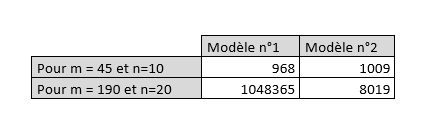

In [41]:
Image("image5.PNG")

On notera que pour de petites valeurs de $n$ et de $m$, le modèle n°1 semble génèrer moins de contraintes que le modèle n°2 mais ce n'est plus le cas lorsque les valeurs de $n$ et de $m$ augmentent. En effet le nombre de contraintes générées par le modèle n°1 semble exploser (à cause du terme $2^n$).

Pour illustrer cela, nous allons déterminer l'évolution du temps d'exécution des 2 modèles lorsque le nombre  de sommets $n$ du graphe augmente. Pour cela nous allons générer plusieurs graphes connexes non orientés avec un nombre croissant de sommets et comparer les temps d'exécution des 2 modèles pour trouver l'arbre couvrant de poids mininmum. (Remarque: Si on suppose qu'entre 2 sommets il ne peut y avoir qu'une seule arête alors un graphe contenant $n$ sommets contiendra au plus $n(n-1)/2$ arêtes et il sera alors saturé en arêtes. Lorsque nous génèrerons nos graphes de $n$ sommets, nous fixerons donc le nombre d'arêtes à $n(n-1)/2$ pour que la taille des graphes générés ne dépende plus que d'un paramètre)

Tous d'abord, on crée une fonction permettant simplement de résoudre un modèle PLNE sans afficher la solution (afin de ne pas encombrer l'affichage):

In [42]:
def JustSolve(Modele,numero):
    Modele.solve(PULP_CBC_CMD())
    if(LpStatus[Modele.status] == "Optimal"):
        print("Modele",numero,": OK")

On compare ensuite nos 2 modèles. Attention la cellule suivante peut mettre un certain temps à s'exécuter (Environ 45 secondes) :

Itération 0
Modele 1 : OK
Modele 2 : OK
Itération 1
Modele 1 : OK
Modele 2 : OK
Itération 2
Modele 1 : OK
Modele 2 : OK
Itération 3
Modele 1 : OK
Modele 2 : OK
Itération 4
Modele 1 : OK
Modele 2 : OK
Itération 5
Modele 1 : OK
Modele 2 : OK
Itération 6
Modele 1 : OK
Modele 2 : OK
Itération 7
Modele 1 : OK
Modele 2 : OK
Itération 8
Modele 1 : OK
Modele 2 : OK
Itération 9
Modele 1 : OK
Modele 2 : OK
Temps total d'excécution : 46.337249994277954


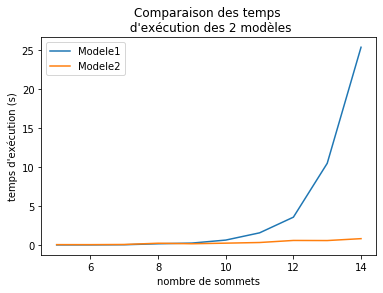

In [43]:
nTest=[i for i in range(5,15)] #On génère successivement des graphes de 5 à 14 sommets
tModele1 = [] #Valeurs du modèle 1
tModele2 = [] #Valeurs du modèle 2
T1 = time.time()
for i in nTest:
    print("Itération",i-5)
    G = genGraphe2(i,int(i*(i-1)/2+1),1,10)
    L,P = ConvertirListe(G.ar)
    t1 = time.time()
    JustSolve(ModelePLNE_1(L,P),1)
    t2 = time.time()
    tModele1.append(t2-t1)
    t1 = time.time()
    JustSolve(ModelePLNE_2(G.ar),2)
    t2 = time.time()
    tModele2.append(t2-t1)
T2 = time.time()
print("Temps total d'excécution :", T2-T1)
plt.plot(nTest,tModele1,label="Modele1")
plt.plot(nTest,tModele2,label="Modele2")
plt.legend()
plt.title("Comparaison des temps \n d'exécution des 2 modèles")
plt.xlabel("nombre de sommets")
plt.ylabel("temps d'exécution (s)")
plt.show()

Sur le graphe affiché précédemment, on remarque que le temps d'exécution du modèle n°1 augmente de plus en plus vite par rapport au temps d'exécution du modèle n°2 ce qui confirme nos hypothèse précédentes. On en déduit qu'il est plus intéressant d'utiliser le second modèle pour des graphes de grande taille. Par exemple, pour des problèmes concret de grande dimension (installation d'un réseau de type fibre couvrant un certain nombre de villes sur une carte) il sera préférable d'utiliser le modèle n°2. En revanche, pour des graphes de plus petite taille (> 10 sommets), on notera que les performances des 2 modèles sont similaires et même que pour des graphes suffisamment petit, le modèle n°1 est plus efficace que le modèle n°2 (cf: exemple du tableau ci-dessus). Ainsi, le choix du modèle  dépendra de la taille du problème à traiter. 

Enfin, nous pouvons comparer les performances du second modèle avec les algorithmes de Prim et Kruskal en comparant leurs temps d'exécution sur des graphes de taille croissante.

Itération 0
Modele 2 : OK
Itération 1
Modele 2 : OK
Itération 2
Modele 2 : OK
Itération 3
Modele 2 : OK
Itération 4
Modele 2 : OK
Itération 5
Modele 2 : OK
Itération 6
Modele 2 : OK
Itération 7
Modele 2 : OK
Itération 8
Modele 2 : OK
Itération 9
Modele 2 : OK
Itération 10
Modele 2 : OK
Itération 11
Modele 2 : OK
Itération 12
Modele 2 : OK
Itération 13
Modele 2 : OK
Itération 14
Modele 2 : OK
Temps total d'excécution : 19.226334810256958


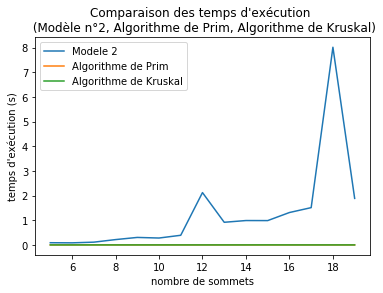

In [44]:
nTest=[i for i in range(5,20)] #On génère successivement des graphes de 5 à 20 sommets
tModele2 = [] #Valeurs du modèle 2
tPrim2 = [] #Valeurs Prim2
tKruskal2 = [] #Valeurs Kruskal2
T1 = time.time()
for i in nTest:
    print("Itération",i-5)
    G = genGraphe2(i,int(i*(i-1)/2+1),1,10)
    t1 = time.time()
    JustSolve(ModelePLNE_2(G.ar),2)
    t2 = time.time()
    tModele2.append(t2-t1)
    t1 = time.time()
    Arbre_P = Prim2(G)
    t2 = time.time()
    tPrim2.append(t2-t1)
    t1 = time.time()
    Arbre_K = Kruskal2(G)
    t2 = time.time()
    tKruskal2.append(t2-t1)
T2 = time.time()
print("Temps total d'excécution :", T2-T1)
plt.plot(nTest,tModele2,label="Modele 2")
plt.plot(nTest,tPrim2,label="Algorithme de Prim")
plt.plot(nTest,tKruskal2,label="Algorithme de Kruskal")
plt.legend()
plt.title("Comparaison des temps d'exécution \n (Modèle n°2, Algorithme de Prim, Algorithme de Kruskal)")
plt.xlabel("nombre de sommets")
plt.ylabel("temps d'exécution (s)")
plt.show()

Sur le graphique précédent, on observe que les temps d'exécution des algorithmes de Prim et de Kruskal sont nettement inférieurs au temps d'exécution du modèle n°2 lorsque la taille du graphe à traiter augmente. Ainsi le second modèle est certes performant pour des problèmes de grande taille par rapport au modèle n°1 mais il reste cependant moins efficace que les algorithmes de Prim et Kruskal (Versions optimisées). Ces 3 méthodes permettent toutes d'obtenir une solution exacte au problème mais les algorithmes semblent plus rapides que le modèle n°2, il sera donc plus intéressant d'utiliser l'un des deux algorithmes plutôt qu'un modèle PLNE pour traiter des problèmes concerts de grande taille. Ici les algorithmes sont plus intéressant qu'un modèle PLNE car ils renvoient une solution exacte et possèdent des compléxités polynomiales (voir logarithmiques pour les versions optimisées) mais nous allons voir que dans certains problème comme celui de 'l'arbre de Steiner dans les graphes', il n'existe pas d'algorithme fournissant une solution exacte et ayant une compléxité polynomiale. Dans ce genre de problème, le modèle PLNE peut devenir cette fois-ci plus intéressant car il devient le seul moyen d'avoir une solution exacte pour des problèmes de grande taille en un temps raisonnable.

## III) Extension du projet : Le problème de l'abre de Steiner dans les graphes

Le problème de l'arbre de Steiner dans les graphes peut s'écrire de la manière suivante. Soit $G=(S,A)$ un graphe non-orienté connexe et $S'$$\subset$ $S$ un sous-ensemble de sommets appelés les terminaux (ou le 'groupe'). Chaque arête $\{i,j\}$$\in$$A$ est munie d’un poids $p_{ij}$. On cherche un arbre $T=(S_{T},A_{T})$ couvrant tous les terminaux (Autrement dit on doit avoir $S'$$\subset$$S_{T}$) et de poids minimum.
Pour modéliser ce problème, on crée de la même manière que pour le modèle n°2, un graphe orienté $\bar{G}=(S,\bar{A})$ tel que $\forall \{u,v\}\in A$ on a $(u,v)\in \bar{A}$ et $(v,u)\in \bar{A}$ (Pour charque arête de $G$, on crée deux arcs de sens inverse dans $\bar{G}$).


### 1) Modèle PLNE

On utilisera à partir de maintenant les notations définies dans l'introduction précédente. Pour modéliser le problème de l'arbre de Steiner dans les graphes, nous allons également utiliser des flots dans le graphe $\bar{G}$.

*Variable :*

- $\forall (i,j) \in \bar{A}$, $x_{ij}$ est une variable de décision binaire $(x_{ij} \in \{0,1\})$ et $x_{ij}=1$ si $\{i,j\}$ est dans $T$ (On a donc $x_{ij}=x_{ji}$). 
- On choisit arbitrairement une source parmi les terminaux que l’on note $s$. $\forall  t \in S'\backslash \{s\}$ et $\forall (i,j)\in \bar{A}$,  $f_{(i,j)}^t$ est une variable binaire $(f_{(i,j)}^t \in \{0,1\})$ donnant la valeur d’un flot $s-t$ compatible de valeur 1 passant sur l’arc $(i,j)$. $f_{(i,j)}^t=1$ s’il existe un flot  $s-t$ valant 1 passant par $(i,j)$.
- $\forall k \in S$, $v_k$ est une variable de décision binaire $(v_k \in \{0,1\})$ et $v_k=1$ si le sommet $k$ est dans $T$.

*Objectif :*

On cherche à minimiser le poids total de $T$ (ici on le divise par 2 car chaque arête est représentée par 2 arcs):

$$\min{\frac{1}{2}\sum_{(i,j)\in \bar{A}}{p_{ij}x_{ij}}}$$


*Contraintes :*

- Dans $\bar{G}$, si on choisit un arc dans un sens alors on prend aussi celui dans l'autre sens : $\forall i,j \in S, x_{ij} = x_{ji}$.
- Si on choisit un arc alors les sommets aux extrémités de cet arc seront dans $T$ : $\forall k \in S$, $   \forall (v,k) \in \delta^{-}(k)$, $x_{vk}\le{v_k}$ et $\forall (k,u) \in \delta^{+}(k)$, $x_{ku}\le v_k$.
- Pour tous les terminaux $t$ différents de $s$, le flot $s-t$ doit respecter la loi de conservation des flux :

$$\forall t \in S'\backslash \{s\}, \forall x \in S\backslash \{s,t\}, \sum_{(u,x)\in \delta^{-}(x)}{f_{(u,x)}^t} = \sum_{(x,v)\in \delta^{+}(x)}{f_{(x,v)}^t}$$

- Pour tous les terminaux $t$ différents de $s$, la flot $s-t$ doit être égale à 1 :

$$\forall t \in S'\backslash \{s\},  \sum_{(s,v)\in \delta^{+}(s)}{f_{(s,v)}^t} = 1$$

$$\forall t \in S'\backslash \{s\},  \sum_{(u,t)\in \delta^{-}(t)}{f_{(u,t)}^t} = 1$$

- Pour tous les terminaux $t$ différents de $s$, le flot $s-t$ entrant dans $s$ doit être nul :

$$\forall t \in S'\backslash \{s\},  \sum_{(u,s)\in \delta^{-}(s)}{f_{(u,s)}^t} = 0$$

- Pour tous les terminaux $t$ différents de $s$, la flot $s-t$ sortant de $t$ doit être nul :

$$\forall t \in S'\backslash \{s\},  \sum_{(t,v)\in \delta^{+}(t)}{f_{(t,v)}^t} = 0$$

- Si $T$ est connexe alors $T$ est un arbre si et seulement si $|A_T| = |S_T|-1$ :

$$\sum_{(i,j) \in \bar{A}}{x_{ij}} = 2 \times (\sum_{k\in S}{v_k}-1)$$

- Un flot ne peut valoir 1 sur une arête que si elle est choisie : $\forall t\in S'\backslash \{s\}, \forall (i,j)\in \bar{A}, f_{(i,j)}^t \le x_{i,j}$





Comme pour le problème de l'arbre couvrant de poids minimum, on crée une fonction chargée de construire le modèle ci-dessus. Elle prendra en argument un double dictionnaire contenant les sommets reliés entre eux en index et les poids des arête en valeur ainsi qu'une liste contenant les sommets des terminaux à couvrir. Cette fonction renvoie le modèle non résolu. 

In [45]:
def ModelePLNE_Steiner(A,terminaux):
    #Création du problème :
    prob = LpProblem("ACPM",LpMinimize)
    S = list(A.keys()).copy()
    n = len(S)
    TerminauxSansSource = terminaux
    s = TerminauxSansSource.pop(0)
    #Variable :
    v={}
    for i in A.keys():
        v[i] = LpVariable("v_"+str(i),0,1,LpInteger)
    
    x={}
    for i in A.keys():
        x[i] = {}
        for j in A[i].keys():
            x[i][j] = LpVariable("x_"+str(i)+"_"+str(j),0,1,LpInteger)
            
    f={}
    for i in A.keys():
        f[i] = {}
        for j in A[i].keys():
            f[i][j] = {}
            for t in TerminauxSansSource:
                f[i][j][t] = LpVariable("f_"+str(i)+"_"+str(j)+"_"+str(t),0,1,LpInteger)
                    
            
    #Objectif :
    prob += 1/2*lpSum([lpSum([x[i][j]*A[i][j] for j in A[i].keys()] for i in A.keys())])

    #Contraintes :

    for i in A.keys():
        for j in A[i].keys():
            prob += x[i][j] == x[j][i]
            
    for t in TerminauxSansSource:
        for a in S:
            if(a not in [s,t]):
                prob += lpSum([f[a][j][t] for j in A[a].keys()]) == lpSum([f[i][a][t] for i in A.keys() if a in list(A[i].keys())])
    
    for t in TerminauxSansSource:
        prob += lpSum([f[s][j][t] for j in A[s].keys()]) == 1
        prob += lpSum([f[i][s][t] for i in A.keys() if s in list(A[i].keys())]) == 0
    
    for t in TerminauxSansSource:
        prob += lpSum([f[i][t][t] for i in A.keys() if t in list(A[i].keys())]) == 1
        prob += lpSum([f[t][j][t] for j in A[t].keys()]) == 0
        
    prob += lpSum([lpSum([x[i][j] for j in A[i].keys()]) for i in A.keys()]) == 2*(lpSum([v[i] for i in A.keys()])-1)
    
    for t in TerminauxSansSource:
        for i in A.keys():
            for j in A[i].keys():
                prob += f[i][j][t] <= x[i][j]
    
    for i in A.keys():
        for j in A[i].keys():
            prob += x[i][j] <= v[i]
            prob += x[j][i] <= v[j]
            
    #Retour du problème :
    return(prob)

On construit ensuite une fonction permettant de résoudre et d'afficher le problème et sa solution sur le même modèle que celles du problème de l'arbre couvrant de poids minimum. Cette fonction prend en paramètre le modèle, son nom et un indicateur booléen. Si cet indicateur est VRAI, on affichera alors l'intégralité du modèle et en particulier les valeurs de chaque variable. Si il est FAUX, l'affichage ne se limitera qu'aux arêtes contenues dans l'abre final et à la valeur de l'objectif (poids de l'arbre):

In [46]:
def SolveAndPrint_Steiner(Modele,name,Affichage_modele=0):
    if(Affichage_modele):
        #Affichage du modèle
        Modele.writeLP(name)
        print(Modele)
        #Résolution:
        print("Solve with CBC")
        Modele.solve(PULP_CBC_CMD())
        print("Status :",LpStatus[Modele.status])
        #Affichage de la solution :
        print("Optimal value =",value(Modele.objective))
        print("Optimal solution :")
        for v in Modele.variables():
            if(v.varValue != 0):
                print(v.name,"=",v.varValue)
    else:
        #Résolution:
        print("Solve with CBC")
        Modele.solve(PULP_CBC_CMD())
        print("Status :",LpStatus[Modele.status])
        #Affichage de la solution :
        AretesTraites = []
        Sommets = []
        regexp = re.compile(r"_(\w+)_(\w+)")
        regexp2 = re.compile(r"v_(\w+)")
        for v in Modele.variables():
            if(v.varValue != 0 and (v.name[0] == 'x' or v.name[0] == 'v')):
                result = regexp.search(v.name)
                result2 = regexp2.search(v.name)
                if result != None:
                    i = result.group(1)
                    j = result.group(2)
                    if([j,i] not in AretesTraites):
                        AretesTraites.append([i,j])
                if result2 != None:
                    Sommets.append((result2.group(1)))
        #Affichage du résultat
        print("RESULTAT :",name)
        for arete in AretesTraites:
            print("L'arbre de Steiner contient l\'arête {",arete[0],",",arete[1],"}")
        print("L'arbre de Steiner contient les sommets : ",Sommets)
        print('Le poids de total de l\'arbre est de : ',value(Modele.objective),end="\n")

Nous allons maintenant tester nos fonctions.

*Exemple n°1:*

In [47]:
#Création du graphe de départ :
G3 = Graphe()
G3.ajouterArete('A','B',5)
G3.ajouterArete('B','C',2)
G3.ajouterArete('C','D',3)
G3.ajouterArete('D','E',2)
G3.ajouterArete('E','A',4)
G3.ajouterArete('E','B',6)
G3.ajouterArete('B','D',4)
#Création de l'ensemble des terminaux :
Terminaux = ['A','E','C']
#Résolution :
SolveAndPrint_Steiner(ModelePLNE_Steiner(G3.ar,Terminaux),"Steiner Exemple 1")

Solve with CBC
Status : Optimal
RESULTAT : Steiner Exemple 1
L'arbre de Steiner contient l'arête { A , E }
L'arbre de Steiner contient l'arête { C , D }
L'arbre de Steiner contient l'arête { D , E }
L'arbre de Steiner contient les sommets :  ['A', 'C', 'D', 'E']
Le poids de total de l'arbre est de :  9.0


*Exemple n°2:*

Cette fois-ci on génère un graphe aléatoire de 10 sommets. L'ensemble des terminaux sera un ensemble de 5 sommets tirés au hasard parmi les sommets du graphe.

In [48]:
#Création du graphe de départ:
n = 10
G4 = genGraphe2(n,int(n*(n-1)/2+1),1,20)  
#Génération aléatoire des terminaux (parmi les sommets du graphe)
groupe = random.sample(G4.so,int(n/2)) 
print("Les terminaux sont:",groupe)
#Résolution:
SolveAndPrint_Steiner(ModelePLNE_Steiner(G4.ar,groupe),"Steiner Exemple aléatoire")

Les terminaux sont: ['10', '3', '8', '1', '9']
Solve with CBC
Status : Optimal
RESULTAT : Steiner Exemple aléatoire
L'arbre de Steiner contient l'arête { 10 , 4 }
L'arbre de Steiner contient l'arête { 10 , 9 }
L'arbre de Steiner contient l'arête { 1 , 4 }
L'arbre de Steiner contient l'arête { 3 , 7 }
L'arbre de Steiner contient l'arête { 4 , 7 }
L'arbre de Steiner contient l'arête { 6 , 8 }
L'arbre de Steiner contient l'arête { 6 , 9 }
L'arbre de Steiner contient les sommets :  ['1', '10', '3', '4', '6', '7', '8', '9']
Le poids de total de l'arbre est de :  19.0


Pour vérifier le bon fonctionnement de notre modèle, il y a quelques cas particuliers du problème de l'arbre de Steiner qui coïncident avec des problèmes plus simples et que l'on peut traiter avec des algorithmes de compléxité polynomiale :

* Si l'ensemble des terminaux et égale à l'ensemble des sommets du graphe (si $S'=S$) alors trouver l'arbre de Steiner couvrant les terminaux $S'$ revient à chercher l'arbre couvrant de poids minimum. On peut donc générer un graphe aléatoirement de taille fixé et vérifier que notre modèle n°2 (Pour l'arbre couvrant de poids minimum) et notre modèle PLNE pour le problème de l'arbre de Steiner renvoient bien les mêmes résultats.

In [49]:
#Création du graphe de départ:
n = 10
G5 = genGraphe2(n,int(n*(n-1)/2+1),1,20)  
#Terminaux
groupe = G5.so 
print("Les terminaux sont:",groupe)
#Résolution avec le modèle PLNE Steiner:
print("\n-----Résolution avec le modèle PLNE Steiner:----------\n")
SolveAndPrint_Steiner(ModelePLNE_Steiner(G5.ar,groupe),"Réslution avec le modèle STEINER")
#Résolution avec le modèle n°2:
print("\n-----Résolution avec le modèle n°2:-------------------\n")
SolveAndPrint_2(ModelePLNE_2(G5.ar),"Résolution avec le MODELE n°2")

Les terminaux sont: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

-----Résolution avec le modèle PLNE Steiner:----------

Solve with CBC
Status : Optimal
RESULTAT : Réslution avec le modèle STEINER
L'arbre de Steiner contient l'arête { 10 , 6 }
L'arbre de Steiner contient l'arête { 1 , 2 }
L'arbre de Steiner contient l'arête { 2 , 3 }
L'arbre de Steiner contient l'arête { 2 , 5 }
L'arbre de Steiner contient l'arête { 4 , 9 }
L'arbre de Steiner contient l'arête { 5 , 9 }
L'arbre de Steiner contient l'arête { 6 , 8 }
L'arbre de Steiner contient l'arête { 7 , 8 }
L'arbre de Steiner contient l'arête { 8 , 9 }
L'arbre de Steiner contient les sommets :  ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
Le poids de total de l'arbre est de :  36.0

-----Résolution avec le modèle n°2:-------------------

Solve with CBC
Status : Optimal
L'arbre contient l'arête { 10 , 6 }
L'arbre contient l'arête { 1 , 2 }
L'arbre contient l'arête { 2 , 5 }
L'arbre contient l'arête { 3 , 4 }
L'arbre con

On retrouve bien le même résultat avec les 2 modèles.

* Si l'ensemble des terminaux est réduit à seulement 2 sommets $v_1$ et $v_2$. Chercher l'arbre de Steiner couvrant ces sommets revient à chercher la chaine la plus courte dans le graphe entre ces 2 sommets. Nous allons donc implémenter l'algorithme de Dijkstra (qui nous servira par la suite pour implémenter une méthode heuristique) et comparer les résultats de notre modèle PLNE lorsqu'il n'y a que 2 terminaux avec le résultat renvoyé par l'algorithme de Dijkstra. On notera ici que l'on ne se concentre que sur le cas où les poids de arêtes sont positifs on peut donc bien implémenter l'algorithme de Dijkstra.

In [50]:
def Dijkstra(G, source):
    #Initialisation:
    L = {}
    predecesseur = {}
    for i in G.so:
        if(i != source):
            L[i] = m.inf
    L[source] = 0
    M = []
    #Boucle:
    while len(M) != len(G.so):
        minimum = m.inf
        s = None
        for i in L:
            if(L[i]<minimum and i not in M):
                minimum = L[i]
                s = i    
        M.append(s)
        for t in G.ar[s]:
            if(t not in M):
                if(L[s]+G.ar[s][t]<L[t]):
                    L[t] = G.ar[s][t] + L[s]
                    predecesseur[t] = s
    return(L,predecesseur)

Notre fonction Dijkstra ci-dessus prend en argument un graphe et un sommet source à partir duquel on détermine les plus courts chemins (ou chaînes) vers les autres sommets du graphe. Cette fonction renvoie un dictionnaire des plus courts chemins vers chaque sommet et un dictionnaire de prédécesseurs. On créé donc également la fonction chemin qui permet de retrouver le plus court chemin (chaîne dans un graphe non orienté) à partir d'un dictionnaire de prédécesseurs.

In [51]:
def Chemin(depart,arrive,Predecesseur):
    Chemin = []
    s = arrive
    while s != depart:
        Chemin.append(s)
        s = Predecesseur[s]
    Chemin.append(s)
    Chemin.reverse()
    return(Chemin)

In [52]:
#Création du graphe de départ:
n = 10
G6 = genGraphe2(n,n*2,1,20)  
#Terminaux
groupe = ['1','5'] 
print("Les terminaux sont:",groupe)
#Résolution avec le modèle PLNE Steiner:
print("\n-----Résolution avec le modèle PLNE Steiner:-------------------------------------------\n")
SolveAndPrint_Steiner(ModelePLNE_Steiner(G6.ar,groupe),"Réslution avec le modèle STEINER")
#Comparaison avec l'algorithme de Dijkstra:
print("\n-----Détermination de la chaine la plus courte avec l'algorithme de Dijkstra:----------\n")
L,P = Dijkstra(G6,'1')
print("La chaine la plus courte de 1 à 5 dans le graphe est de taille:",L['5'])
print("La chaine correspondante est",Chemin('1','5',P))

Les terminaux sont: ['1', '5']

-----Résolution avec le modèle PLNE Steiner:-------------------------------------------

Solve with CBC
Status : Optimal
RESULTAT : Réslution avec le modèle STEINER
L'arbre de Steiner contient l'arête { 1 , 5 }
L'arbre de Steiner contient les sommets :  ['1', '5']
Le poids de total de l'arbre est de :  5.0

-----Détermination de la chaine la plus courte avec l'algorithme de Dijkstra:----------

La chaine la plus courte de 1 à 5 dans le graphe est de taille: 5
La chaine correspondante est ['1', '5']


On remarque que le poids de l'arbre de Steiner obtenue est bien égale à la longeur de la chaine la plus courte reliant les 2 sommets. En revanche la chaine renvoyée par l'algorithme de Dijkstra ne correspond pas forcément à l'arbre de Steiner (En effet, il n'y a pas toujours unicité de la chaine la plus courte).

### 2) Implémentation d'une méthode Heuristique

Nous allons maintenant implémenter l'algorithme de Takahashi et Matsuyama qui est un algorithme heuristique permettant de trouver une solution approchée de l'arbre de Steiner en un temps raisonnable. Notre modèle PLNE codé précédement fournit une solution exacte au problème contrairement à l'algorithme de Takahashi et Matsuyama. Avec cet algorithme, on s'attends à trouver une solution très proche de celle du modèle PLNE (Mais le poids de l'arbre obtenue avec l'algorithme de Takahashi et Matsuyama ne devrait pas être inférieur à celui de l'arbre obtenu avec le modèle PLNE). Il sera intéressant dans un second temps de comparer les performances des 2 méthodes et d'estimer la fiabilité de la méthode heuristique. Le pseudo code de l'algorithme est le suivant:

*Initialisation:*  
- Initialiser l'arbre en choisissant arbitrairement un noeud parmis les terminaux.

*Jusqu'au dernier noeud des terminaux:* 
- Calculer les distances des noeuds parmi les terminaux non encore choisis avec l'arbre ainsi obtenu.
- Ajouter à l'arbre couvrant le noeud le plus proche (en utilisant le plus court chemin entre le noeud et l'arbre).

On utilisera donc l'algorithme de Dijkstra implémenté précédemment.

On construit maintenant notre algorithme heuristique avec la fonction SteinerTree qui prend en argument un graphe connexe non orienté et une liste de sommets contenant les terminaux. La fonction renvoie un graphe qui est l'arbre de Steiner ainsi que son poids total. 

In [53]:
def SteinerTree(G,groupe):
    T = Graphe()
    Poid_total = 0
    noeud = groupe.pop(0)
    T.ajouterSommet(noeud)
    while len(groupe)>0:
        Distance_min = m.inf
        noeud = None
        C = None
        for v in groupe:
            Longueur, Predecesseurs = Dijkstra(G,v)
            for s in T.so:
                if(Longueur[s]<Distance_min):
                    Distance_min = Longueur[s]
                    noeud = v
                    C = Chemin(v,s,Predecesseurs)
        groupe.remove(noeud)
        for i in range(len(C)-1):
            T.ajouterArete(C[i],C[i+1],G.ar[C[i]][C[i+1]])
            Poid_total += G.ar[C[i]][C[i+1]]
    return(T,Poid_total)
        

Maintenant, on peut tester cet algorithme en comparant son résultat avec celui du modèle PLNE.

In [54]:
T1 = time.time()
G7 = genGraphe2(15,30,1,20)  
gr1 = random.sample(G7.so,8)
print('Terminaux :',gr1)
gr2 = gr1.copy()
print("---------PLNE------------")
t1 = time.time()
SolveAndPrint_Steiner(ModelePLNE_Steiner(G7.ar,gr1),"Steiner Test 1")
t2 = time.time()
print("Temps d'éxecution pour le modèle PLNE :",t2-t1,"secondes")
print("---------HEURISTIQUE------------")
t1 = time.time()
T,P = SteinerTree(G7,gr2)
t2 = time.time()
print("Temps d'éxecution pour l'Heuristique :",t2-t1,"secondes")
print('Le poids total de l\'arbre est de :',P)
T2 = time.time()
print("Temps total d'execution :",T2-T1,"secondes")

Terminaux : ['12', '15', '7', '1', '11', '10', '6', '5']
---------PLNE------------
Solve with CBC
Status : Optimal
RESULTAT : Steiner Test 1
L'arbre de Steiner contient l'arête { 10 , 3 }
L'arbre de Steiner contient l'arête { 11 , 12 }
L'arbre de Steiner contient l'arête { 11 , 7 }
L'arbre de Steiner contient l'arête { 15 , 3 }
L'arbre de Steiner contient l'arête { 1 , 2 }
L'arbre de Steiner contient l'arête { 2 , 3 }
L'arbre de Steiner contient l'arête { 2 , 7 }
L'arbre de Steiner contient l'arête { 5 , 6 }
L'arbre de Steiner contient l'arête { 6 , 7 }
L'arbre de Steiner contient les sommets :  ['1', '10', '11', '12', '15', '2', '3', '5', '6', '7']
Le poids de total de l'arbre est de :  27.0
Temps d'éxecution pour le modèle PLNE : 0.17971181869506836 secondes
---------HEURISTIQUE------------
Temps d'éxecution pour l'Heuristique : 0.0 secondes
Le poids total de l'arbre est de : 27
Temps total d'execution : 0.17971181869506836 secondes


On observe que la plupart du temps, le poids de l'arbre renvoyé par l'algorithme Heuristique est égal au poids de l'arbre renvoyé par le modèle PLNE. Parfois le résultat (le poids de l'arbre) de l'algorithme heuristique est légèrement supérieur à celui du modèle PLNE. En revanche, le temps d'exécution de l'algorithme heuristique est largement inférieur à celui du modèle PLNE. Nous allons préciser ces derniers points par la suite.

### 3) Analyse et comparaision des 2 méthodes

Nous avons remarqué que dans certains cas la méthode heuristique renvoyait un résultat légèrement supérieur au résultat exacte. Nous allons donc essayer de mesurer empiriquement le pourcentage d'erreur de la méthode heuristique. Pour cela, nous allons réaliser 100 simulations successives au cours desquels nous allons résoudre le problème avec l'algorithme heuristique et avec le modèle PLNE. Sur ces 100 simulations, on comptera le nombre d'erreurs de l'algorithme heuristique. Pour faciliter la résolution du modèle PLNE et ne pas encombrer l'affichage, on crée la fonction suivant qui ne fait que résoudre et afficher l'objectif (sans afficher tout le modèle).

In [55]:
def JustSolve(Modele):
    Modele.solve(PULP_CBC_CMD())
    if(LpStatus[Modele.status] == "Optimal"):
        print("Modèle PLNE OK")
    else:
        print("Erreur")
    return(value(Modele.objective))

On effectue ensuite 100 test. Pour chaque test, on compare le résultat obtenu (c'est-à-dire le poids minimal obtenu) par l'heuristique avec la solution du PLNE et on compte le nombre de fois où il y a eu une différence.

In [56]:
#Attention: Le temps d'exécution de cette cellule est assez long (20 secondes environ)
difference = 0
NbTest = 100
T1 = time.time()
for test in range(NbTest):
    print("Test n°:",test)
    G = genGraphe2(10,20,1,20)  
    gr1 = random.sample(G.so,3) 
    gr2 = gr1.copy()
    P1 = JustSolve(ModelePLNE_Steiner(G.ar,gr1))
    print("Poids PLNE:",P1)
    T,P2 = SteinerTree(G,gr2)
    print("Poids Heuristique:",P2)
    if P1!=P2: difference+=1
T2 = time.time()
print("Temps total d'execution :",T2-T1,"secondes")
print("Nombre de différences sur",NbTest,"tests",":",difference)
print("L'heuriste renvoie le même résultat que le modèle PLNE dans",100-difference,"% des cas (Fréquence empirique)")

Test n°: 0
Modèle PLNE OK
Poids PLNE: 18.0
Poids Heuristique: 18
Test n°: 1
Modèle PLNE OK
Poids PLNE: 19.0
Poids Heuristique: 19
Test n°: 2
Modèle PLNE OK
Poids PLNE: 23.0
Poids Heuristique: 23
Test n°: 3
Modèle PLNE OK
Poids PLNE: 16.0
Poids Heuristique: 16
Test n°: 4
Modèle PLNE OK
Poids PLNE: 19.0
Poids Heuristique: 19
Test n°: 5
Modèle PLNE OK
Poids PLNE: 16.0
Poids Heuristique: 16
Test n°: 6
Modèle PLNE OK
Poids PLNE: 7.0
Poids Heuristique: 7
Test n°: 7
Modèle PLNE OK
Poids PLNE: 14.0
Poids Heuristique: 14
Test n°: 8
Modèle PLNE OK
Poids PLNE: 25.0
Poids Heuristique: 25
Test n°: 9
Modèle PLNE OK
Poids PLNE: 38.0
Poids Heuristique: 38
Test n°: 10
Modèle PLNE OK
Poids PLNE: 17.0
Poids Heuristique: 17
Test n°: 11
Modèle PLNE OK
Poids PLNE: 32.0
Poids Heuristique: 32
Test n°: 12
Modèle PLNE OK
Poids PLNE: 3.0
Poids Heuristique: 3
Test n°: 13
Modèle PLNE OK
Poids PLNE: 15.0
Poids Heuristique: 15
Test n°: 14
Modèle PLNE OK
Poids PLNE: 38.0
Poids Heuristique: 38
Test n°: 15
Modèle PLNE 

Sur 100 simulations, pour des graphes de 10 sommets et de 19 arêtes, le nombre de différences observées entre le résultat de l'algorithme heuristique et le modèle PLNE est très faible. Il semblerait cependant que ce nombre de différences varie en fonction du nombre de terminaux. Par exemple, pour la réalisation précédente, il n'y avait que 3 terminaux et on trouve en moyenne (selon les exécutions) que le nombre de différences varie entre 2 et 4.

Nous avons brievement étudié l'impact du nombre de terminaux sur le nombre de différences observé entre les 2 méthodes. Nous avons fixé la taille des graphes à 10 sommet et 19 arêtes et avons fait varier le nombre de terminaux de 2 à 10. Pour un nombre de terminaux fixé nous avons effectué 10 exécutions d'un jeu de 100 simulations (comme dans la cellule précédente) et effectué la moyenne du nombre de différences sur ces 10 exécutions (afin d'obtenir plus de précision sur la fréquence d'erreur). On obtient les résultats suivants : 

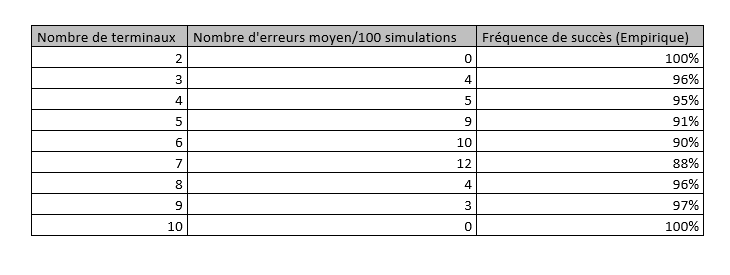

In [57]:
Image("image6.PNG")

On notera que la fréquence de succès de l'algorithme est la élevée lorsque le nombre de terminaux est soit proche de 2 ou proche du nombre total de sommets. Pour un nombre de terminaux se rapprochant de la moitité du nombre de sommet, la fréquence de réussite de l'algorithme sera la plus faible.

Nous avons maintenant une idée de la fiabilité de l'algorithme heuristique (pour des graphes à traiter de petite taille). Nous allons enfin comparer le temps d'exécution de cet algorithme avec celui du modèle PLNE lorsque la taille du graphe à traiter augmente. On choisit de faire augmenter le nombre $n$ de sommet et on fixe le nombre d'arêtes à $n(n-1)/2$ et le nombre de terminaux à $\left\lfloor\dfrac{n}{2}\right\rfloor$. 

Itération 0
Modèle PLNE OK
Itération 1
Modèle PLNE OK
Itération 2
Modèle PLNE OK
Itération 3
Modèle PLNE OK
Itération 4
Modèle PLNE OK
Itération 5
Modèle PLNE OK
Itération 6
Modèle PLNE OK
Itération 7
Modèle PLNE OK
Itération 8
Modèle PLNE OK
Itération 9
Modèle PLNE OK
Itération 10
Modèle PLNE OK
Itération 11
Modèle PLNE OK
Itération 12
Modèle PLNE OK
Itération 13
Modèle PLNE OK
Itération 14
Modèle PLNE OK
Temps total d'excécution : 71.52317118644714


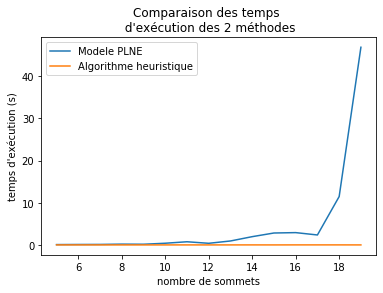

In [58]:
nTest=[i for i in range(5,20)] 
tModelePLNE = []
tAlgorithme = [] 
T1 = time.time()
for i in nTest:
    print("Itération",i-5)
    G = genGraphe2(i,int(i*(i-1)/2+1),1,10)
    gr1 = random.sample(G.so,int(i/2)) 
    gr2 = gr1.copy()
    t1 = time.time()
    JustSolve(ModelePLNE_Steiner(G.ar,gr1))
    t2 = time.time()
    tModelePLNE.append(t2-t1)
    t1 = time.time()
    T = SteinerTree(G,gr2)
    t2 = time.time()
    tAlgorithme.append(t2-t1)
T2 = time.time()
print("Temps total d'excécution :", T2-T1)
plt.plot(nTest,tModelePLNE,label="Modele PLNE")
plt.plot(nTest,tAlgorithme,label="Algorithme heuristique")
plt.legend()
plt.title("Comparaison des temps \n d'exécution des 2 méthodes")
plt.xlabel("nombre de sommets")
plt.ylabel("temps d'exécution (s)")
plt.show()

Sur le graphique précédent, on remarque que le temps d'exécution du modèle PLNE croit beaucoup plus vite que celui de l'algorithme heuristique lorsque le nombre de sommets du graphe à traiter augmente. En effet, pour un graphe entré possèdant $n$ sommets, $m$ arêtes et $k$ terminaux, le modèle va générer $n+2 m+2 m (k-1)$ variables et $2 m + (k-1)(n-2) + 4 (k-1) + 1 + 2(k-1)m +4 m $ contraintes.

On a finalement 2 méthodes pour résoudre le problème de l'arbre de Steiner dans les graphes : Un modèle PLNE qui fournit une solution exacte mais dont le temps d'exécution croît fortement lorsque la taille du graphe augmente et un algorithme heuristique fournissant une solution approchée de manière plus rapide. La fréquence de réussite de l'algorithme est relativement bonne (Dans nos tests précédent, nous n'avons pas trouvé de fréquence de réussite inférieures à 85%) et même en cas d'erreur, la solution obtenue est très proche de la solution exacte. Le choix d'utilisation de l'une de ces 2 méthodes dans des cas concrets dépendra de la taille des instances à traiter. Pour des graphes de petite taille, on peut utiliser le modèle PLNE et obtenir une solution exacte tandis pour des graphes plus grands on peut utiliser la méthode heuristique pour obtenir une solution en un minimum de temps mais il faudra se satisfaire d'une solution approchée et surtout savoir estimer l'erreur de cette solution.  

## Conclusion:

Lors de la réalisation de ce projet, nous avons eu l’occasion de développer plusieurs versions de nos algorithmes, afin d’obtenir des algorithmes optimisés et rapides dans leur exécution. Nous avons dû mettre en place différentes techniques pour cette optimisation, comme réduire le nombre de boucles internes des fonctions, ou utiliser des modules externes. En testant avec un grand nombre d’exemples tirés du cours ou générés aléatoirement, nous avons su mettre en évidence les complexités des algorithmes de Prim et de Krustal telles que démontrées dans le cours.

En utilisant les différents modèles de PLNE, nous avons su modéliser le problème de l’arbre couvrant de poids minimum avec PuLP. Cela nous a permis de minimiser sous forme linéaire ce problème et de pouvoir le résoudre avec des algorithmes très efficaces développés en programmation linaire. Cette approche était très intéressante car différente de la programmation plus classique à laquelle nous nous sommes livrés au travers des algorithmes de Krustal et de Prim.

Enfin, en travaillant sur le problème des arbres de Steiner, nous avons pu dépasser le problème de l’arbre couvrant de poids minimum et nous intéresser à un problème plus complexe et avec des contraintes différentes. Cela nous a obligé à nous documenter sur le sujet, à trouver des articles et rapports sur le sujet, afin de bien assimiler le problème et ses conséquences sur sa programmation en PLNE. L’implémentation d’une méthode heuristique (modèle de Takahashi et Matsuyama) et sa comparaison avec la formulation PLNE nous a permis de tester les limites et les différences en temps de calcul de deux approches différentes. Les méthodes heuristiques fournissent une approximation du résultat mais qui peut être suffisamment intéressante dans le cas d’un grand nombre de données (ici de nœuds et d’arrêtes). 


Au cours de la réalisation de ce projet, nous avons rencontré quelques difficultés et avons dû faire certains choix qui ont influencé la réalisation entière du projet. Parmi eux, la classe Graphe que nous avions décidé de créer était trop générique et rendait la complexité beaucoup plus importante ; nous obligeant à la redéfinir complètement. On peut aussi mentionner la difficulté que nous avons eu à retrouver la complexité théorique des deux algorithmes. En effet, il n’était pas évident de trouver les paramètres sur lesquels jouer pour réduire la complexité et la rendre cohérente avec la théorie.

On pourrait mentionner, comme pistes d’améliorations possibles à suivre, l’utilisation d’autres méthodes heuristiques dans la programmation du problème des arbres de Steiner dans les graphes. Cela permettrait d’avoir une meilleure idée de la différence de temps d’exécution et de fiabilité de ce genre de méthodes (Takahashi et Matsuyama semble être une bonne méthode mais d’autres existent). Une autre piste d’amélioration est la réduction de la complexité de l’algorithme de Prim par l’utilisation des tas de Fibonacci dans sa programmation (alors que la version la plus optimisée de cet algorithme utilise les tas-min binaires).
